## Introduction
Success in any financial market requires one to identify solid investments. When a stock or derivative is undervalued, it makes sense to buy. If it's overvalued, perhaps it's time to sell. While these finance decisions were historically made manually by professionals, technology has ushered in new opportunities for retail investors. Data scientists, specifically, may be interested to explore quantitative trading, where decisions are executed programmatically based on predictions from trained models.

There are plenty of existing quantitative trading efforts used to analyze financial markets and formulate investment strategies. To create and execute such a strategy requires both historical and real-time data, which is difficult to obtain especially for retail investors. This competition will provide financial data for the Japanese market, allowing retail investors to analyze the market to the fullest extent.

Japan Exchange Group, Inc. (JPX) is a holding company operating one of the largest stock exchanges in the world, Tokyo Stock Exchange (TSE), and derivatives exchanges Osaka Exchange (OSE) and Tokyo Commodity Exchange (TOCOM). JPX is hosting this competition and is supported by AI technology company AlpacaJapan Co.,Ltd.

Exploratory data analysis is a great way of understanding and analyzing the data sets. EDA technique is extensively used in this notebook to summarize the main characteristics of data sets and to visualize them through different graphs and plots.

## About this Notebook
In this notebook, We will perform exploratory data analysis, mostly using files from the train files/ directory, to aid in the initial comprehension of the data; moreover, a simple baseline model will be created to demonstrate the use of the time series API.

# Table of Content
1. Introduction
2. Setup and Import
3. Getting to know the Data
4. Visualisation


## Objectives 
* To visualize stock price by examining the trend & price movement for viability of potential investment.

## Importation of all relevant pakages & Data

In [1]:
#Importing necessary packages

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import tqdm
import random
from scipy.optimize import minimize, Bounds, LinearConstraint, linprog
import base64
from io import BytesIO
import os
import gc
!pip install -q mplfinance
import mplfinance as mpl
from ipywidgets import HTML

# Turn off the max column width so the images won't be truncated
pd.set_option('display.max_colwidth', None)
 
# Turning off the max column will display all the data
# if gathering into sets / array we might want to restrict to a few items
pd.set_option('display.max_seq_items', 3)

from multiprocessing import Pool, cpu_count

import warnings

# Configuration
warnings.simplefilter('ignore')
#pd.set_option('max_column', None)
sns.set_style("darkgrid")
colors = sns.color_palette('Set2')



# Parallel df groupby func
def applyParallel(dfGrouped, func):
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)



# Utility function
def sparkline(data, isBar=False, figsize=(7, 0.75), **kwargs):
    """
    creates a sparkline charts
    """
    data = list(data)
    
    *_, ax = plt.subplots(1, 1, figsize=figsize, **kwargs)
    if isBar:
        ax.bar(list(range(len(data))),data)
    else:
        c= 'green' if data[-1]> data[1] else 'red'
        ax.plot(data, color = c)
        ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1, color=c)
    ax.set_axis_off()
    plt.margins(0)

    img = BytesIO()
    plt.savefig(img, pad_inches = 0,bbox_inches= 'tight')
    img.seek(0)
    plt.close()
    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()).decode())

#### Loading Data

In [2]:
#For local path
path = "../data/train_files"
path_stocklist = "../data"

In [3]:
%%time

df_prices = pd.read_csv(os.path.join(path, 'stock_prices.csv'))
df_prices_sec = pd.read_csv(os.path.join(path, 'secondary_stock_prices.csv'))
df_fins = pd.read_csv(os.path.join(path, 'financials.csv'))
df_opts = pd.read_csv(os.path.join(path, 'options.csv'))
df_trades = pd.read_csv(os.path.join(path, 'trades.csv'))
stock_list = pd.read_csv(os.path.join(path_stocklist, "stock_list.csv"))

CPU times: user 8.53 s, sys: 1.74 s, total: 10.3 s
Wall time: 11.2 s


In [4]:
df_prices.head()

RowId        Date  SecuritiesCode    Open    High     Low   Close  \
0  20170104_1301  2017-01-04            1301  2734.0  2755.0  2730.0  2742.0   
1  20170104_1332  2017-01-04            1332   568.0   576.0   563.0   571.0   
2  20170104_1333  2017-01-04            1333  3150.0  3210.0  3140.0  3210.0   
3  20170104_1376  2017-01-04            1376  1510.0  1550.0  1510.0  1550.0   
4  20170104_1377  2017-01-04            1377  3270.0  3350.0  3270.0  3330.0   

    Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag    Target  
0    31400               1.0               NaN            False  0.000730  
1  2798500               1.0               NaN            False  0.012324  
2   270800               1.0               NaN            False  0.006154  
3    11300               1.0               NaN            False  0.011053  
4   150800               1.0               NaN            False  0.003026

In [5]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [6]:
df_prices_sec.head()

RowId        Date  SecuritiesCode     Open     High      Low  \
0  20170104_1305  2017-01-04            1305   1594.0   1618.0   1594.0   
1  20170104_1306  2017-01-04            1306   1575.0   1595.0   1573.0   
2  20170104_1308  2017-01-04            1308   1557.0   1580.0   1557.0   
3  20170104_1309  2017-01-04            1309  28810.0  29000.0  28520.0   
4  20170104_1311  2017-01-04            1311    717.0    735.0    717.0   

     Close   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
0   1615.0   538190               1.0               NaN            False   
1   1593.0  2494980               1.0               NaN            False   
2   1578.0   526100               1.0               NaN            False   
3  28780.0      403               1.0               NaN            False   
4    734.0     5470               1.0               NaN            False   

     Target  
0 -0.001855  
1 -0.000627  
2 -0.001900  
3  0.005237  
4  0.001359

In [7]:
df_fins.head()

DisclosureNumber       DateCode        Date  SecuritiesCode DisclosedDate  \
0      2.016121e+13  20170104_2753  2017-01-04          2753.0    2017-01-04   
1      2.017010e+13  20170104_3353  2017-01-04          3353.0    2017-01-04   
2      2.016123e+13  20170104_4575  2017-01-04          4575.0    2017-01-04   
3      2.017010e+13  20170105_2659  2017-01-05          2659.0    2017-01-05   
4      2.017011e+13  20170105_3050  2017-01-05          3050.0    2017-01-05   

  DisclosedTime  DisclosedUnixTime                         TypeOfDocument  \
0      07:30:00       1.483483e+09  3QFinancialStatements_Consolidated_JP   
1      15:00:00       1.483510e+09  3QFinancialStatements_Consolidated_JP   
2      12:00:00       1.483499e+09                       ForecastRevision   
3      15:00:00       1.483596e+09  3QFinancialStatements_Consolidated_JP   
4      15:30:00       1.483598e+09                       ForecastRevision   

  CurrentPeriodEndDate TypeOfCurrentPeriod  ... ForecastEarningsPerShare  \
0           2016-12-31                  3Q  ...                   319.76   
1           2016-11-30                  3Q  ...                   485.36   
2           2016-12-31                  2Q  ...                   -93.11   
3           2016-11-30                  3Q  ...                   285.05   
4           2017-02-28                  FY  ...                      NaN   

  ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements  \
0                                                           NaN   
1                                                           NaN   
2                                                           NaN   
3                                                           NaN   
4                                                           NaN   

  MaterialChangesInSubsidiaries ChangesBasedOnRevisionsOfAccountingStandard  \
0                         False                                        True   
1                         False                                        True   
2                           NaN                                         NaN   
3                         False                                        True   
4                           NaN                                         NaN   

  ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard  \
0                                                    False   
1                                                    False   
2                                                      NaN   
3                                                    False   
4                                                      NaN   

  ChangesInAccountingEstimates RetrospectiveRestatement  \
0                        False                    False   
1                        False                    False   
2                          NaN                      NaN   
3                        False                    False   
4                          NaN                      NaN   

  NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock  \
0                                                                    6848800.0   
1                                                                    2035000.0   
2                                                                          NaN   
3                                                                   31981654.0   
4                                                                          NaN   

  NumberOfTreasuryStockAtTheEndOfFiscalYear AverageNumberOfShares  
0                                         －             6848800.0  
1                                    118917             1916083.0  
2                                       NaN                   NaN  
3                                     18257            31963405.0  
4                                       NaN                   NaN  

[5 rows x 45 columns]

In [8]:
df_opts.head()

DateCode        Date  OptionsCode  WholeDayOpen  WholeDayHigh  \
0  20170104_132010018  2017-01-04    132010018         650.0         650.0   
1  20170104_132010118  2017-01-04    132010118           0.0           0.0   
2  20170104_132010218  2017-01-04    132010218           0.0           0.0   
3  20170104_132010318  2017-01-04    132010318           0.0           0.0   
4  20170104_132010518  2017-01-04    132010518           0.0           0.0   

   WholeDayLow  WholeDayClose NightSessionOpen NightSessionHigh  \
0        480.0          480.0           0.0000           0.0000   
1          0.0            0.0           0.0000           0.0000   
2          0.0            0.0           0.0000           0.0000   
3          0.0            0.0           0.0000           0.0000   
4          0.0            0.0           0.0000           0.0000   

  NightSessionLow  ... Putcall  LastTradingDay  SpecialQuotationDay  \
0          0.0000  ...       1        20170112             20170113   
1          0.0000  ...       1        20170112             20170113   
2          0.0000  ...       1        20170112             20170113   
3          0.0000  ...       1        20170112             20170113   
4          0.0000  ...       1        20170112             20170113   

   SettlementPrice  TheoreticalPrice  BaseVolatility  ImpliedVolatility  \
0            480.0          478.4587         17.4736            17.5865   
1            575.0          571.1385         17.4736            16.5000   
2            680.0          677.3710         17.4736            15.8644   
3            795.0          791.0383         17.4736            15.2288   
4            910.0          909.9947         17.4736            14.5932   

   InterestRate  DividendRate  Dividend  
0        0.0091           0.0       0.0  
1        0.0091           0.0       0.0  
2        0.0091           0.0       0.0  
3        0.0091           0.0       0.0  
4        0.0091           0.0       0.0  

[5 rows x 31 columns]

In [9]:
df_trades.head()

Date StartDate EndDate Section  TotalSales  TotalPurchases  \
0  2017-01-04       NaN     NaN     NaN         NaN             NaN   
1  2017-01-05       NaN     NaN     NaN         NaN             NaN   
2  2017-01-06       NaN     NaN     NaN         NaN             NaN   
3  2017-01-10       NaN     NaN     NaN         NaN             NaN   
4  2017-01-11       NaN     NaN     NaN         NaN             NaN   

   TotalTotal  TotalBalance  ProprietarySales  ProprietaryPurchases  ...  \
0         NaN           NaN               NaN                   NaN  ...   
1         NaN           NaN               NaN                   NaN  ...   
2         NaN           NaN               NaN                   NaN  ...   
3         NaN           NaN               NaN                   NaN  ...   
4         NaN           NaN               NaN                   NaN  ...   

   CityBKsRegionalBKsEtcTotal  CityBKsRegionalBKsEtcBalance  TrustBanksSales  \
0                         NaN                           NaN              NaN   
1                         NaN                           NaN              NaN   
2                         NaN                           NaN              NaN   
3                         NaN                           NaN              NaN   
4                         NaN                           NaN              NaN   

   TrustBanksPurchases  TrustBanksTotal  TrustBanksBalance  \
0                  NaN              NaN                NaN   
1                  NaN              NaN                NaN   
2                  NaN              NaN                NaN   
3                  NaN              NaN                NaN   
4                  NaN              NaN                NaN   

   OtherFinancialInstitutionsSales  OtherFinancialInstitutionsPurchases  \
0                              NaN                                  NaN   
1                              NaN                                  NaN   
2                              NaN                                  NaN   
3                              NaN                                  NaN   
4                              NaN                                  NaN   

   OtherFinancialInstitutionsTotal  OtherFinancialInstitutionsBalance  
0                              NaN                                NaN  
1                              NaN                                NaN  
2                              NaN                                NaN  
3                              NaN                                NaN  
4                              NaN                                NaN  

[5 rows x 56 columns]

In [10]:
stock_list.head()

SecuritiesCode  EffectiveDate  \
0            1301       20211230   
1            1305       20211230   
2            1306       20211230   
3            1308       20211230   
4            1309       20211230   

                                                   Name  \
0                                      KYOKUYO CO.,LTD.   
1                                       Daiwa ETF-TOPIX   
2                 NEXT FUNDS TOPIX Exchange Traded Fund   
3                Nikko Exchange Traded Index Fund TOPIX   
4  NEXT FUNDS ChinaAMC SSE50 Index Exchange Traded Fund   

           Section/Products NewMarketSegment 33SectorCode  \
0  First Section (Domestic)     Prime Market           50   
1                ETFs/ ETNs              NaN            -   
2                ETFs/ ETNs              NaN            -   
3                ETFs/ ETNs              NaN            -   
4                ETFs/ ETNs              NaN            -   

                        33SectorName 17SectorCode 17SectorName  \
0  Fishery, Agriculture and Forestry            1       FOODS    
1                                  -            -            -   
2                                  -            -            -   
3                                  -            -            -   
4                                  -            -            -   

  NewIndexSeriesSizeCode NewIndexSeriesSize   TradeDate    Close  \
0                      7      TOPIX Small 2  20211230.0   3080.0   
1                      -                  -  20211230.0   2097.0   
2                      -                  -  20211230.0   2073.5   
3                      -                  -  20211230.0   2053.0   
4                      -                  -  20211230.0  44280.0   

   IssuedShares  MarketCapitalization  Universe0  
0  1.092828e+07          3.365911e+10       True  
1  3.634636e+09          7.621831e+12      False  
2  7.917718e+09          1.641739e+13      False  
3  3.736943e+09          7.671945e+12      False  
4  7.263200e+04          3.216145e+09      False

## Getting to Know the Data

Before we can start visualizing, Lets have an overview of the data. We will explore each of the dataset

### 1. Stock_prices
#### File Description
The main file of interest, which includes the target column and the daily closing price for each stock. Column information contained in stock price spec.csv is as follows:

* RowId: Unique ID of price records, the combination of Date and SecuritiesCode.
* Date: Trade date.
* SecuritiesCode: Local securities code.
* Open: First traded price on a day.
* High: Highest traded price on a day.
* Low: Lowest traded price on a day.
* Close: Last traded price on a day.
* Volume: Number of traded stocks on a day.
* AdjustmentFactor: Used to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares).
* ExpectedDividend: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
* SupervisionFlag: Flag of securities under supervision and securities to be delisted, for more information, please see here.
* Target: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is trade date.

In [11]:
def summarize(df, file_name, n_rows_to_show=5):
    """Simply summarize the given DataFrame.
    
    Parameters:
        df: pd.DataFrame, raw DataFrame
        file_name: str, name of the file
        n_rows_to_show: int, number of rows to show 
    """
    print(f"=====Summary of {file_name}=====")
    print(f"Shape: {df.shape}")
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("NaN ratio:")
    display(nan_ratio)   
    
    display(df.head(n_rows_to_show))
    

In [12]:
summarize(df_prices, "stock_prices.csv")

=====Summary of stock_prices.csv=====
Shape: (2332531, 12)
NaN ratio:


ExpectedDividend      Open      High       Low     Close    Target  \
NaN Ratio         99.191222  0.326169  0.326169  0.326169  0.326169  0.010204   

           RowId  Date  SecuritiesCode  Volume  AdjustmentFactor  \
NaN Ratio    0.0   0.0             0.0     0.0               0.0   

           SupervisionFlag  
NaN Ratio              0.0

RowId        Date  SecuritiesCode    Open    High     Low   Close  \
0  20170104_1301  2017-01-04            1301  2734.0  2755.0  2730.0  2742.0   
1  20170104_1332  2017-01-04            1332   568.0   576.0   563.0   571.0   
2  20170104_1333  2017-01-04            1333  3150.0  3210.0  3140.0  3210.0   
3  20170104_1376  2017-01-04            1376  1510.0  1550.0  1510.0  1550.0   
4  20170104_1377  2017-01-04            1377  3270.0  3350.0  3270.0  3330.0   

    Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag    Target  
0    31400               1.0               NaN            False  0.000730  
1  2798500               1.0               NaN            False  0.012324  
2   270800               1.0               NaN            False  0.006154  
3    11300               1.0               NaN            False  0.011053  
4   150800               1.0               NaN            False  0.003026

#### Keys

RowID is composed of Date and SecuritiesCode.

In [13]:
row_id = (df_prices['Date'].apply(lambda date: ''.join(date.split('-'))+'_')
          + df_prices['SecuritiesCode'].astype(str))
assert (df_prices['RowId'] == row_id).all()

In [14]:
n_dates = df_prices['Date'].nunique()
date_min, date_max = df_prices['Date'].min(), df_prices['Date'].max()
n_stocks = df_prices['SecuritiesCode'].nunique()

print(f"Number of unique dates: {n_dates} ({date_min} ~ {date_max})\n"
      f"Number of unique stocks: {n_stocks}")

Number of unique dates: 1202 (2017-01-04 ~ 2021-12-03)
Number of unique stocks: 2000


Over 90% of stocks have records for the entire training period from January 4, 2017 to December 3, 2021. However, we must continue to monitor missing values in particular columns (e.g., ExpectedDividend, price columns).

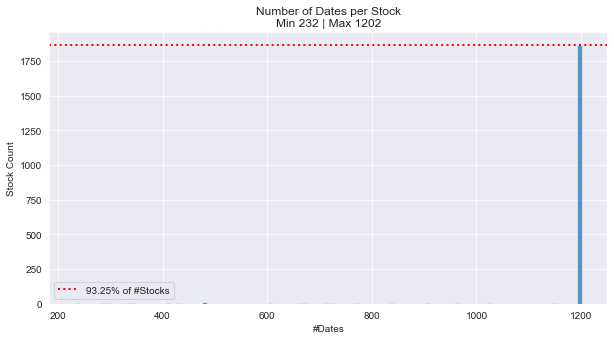

In [15]:
n_dates_per_stock = df_prices.groupby(['SecuritiesCode'])['Date'].count()
stock_cnt_max = (n_dates_per_stock == n_dates_per_stock.max()).sum()
stock_ratio_max = stock_cnt_max / len(n_dates_per_stock) * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_dates_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% of #Stocks')
ax.set_title(f"Number of Dates per Stock\nMin {n_dates_per_stock.min()} | "
             f"Max {n_dates_per_stock.max()}")
ax.set_xlabel("#Dates")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Approximately 20% of trading dates have all 2000 stocks' records. Again, the missing values should be noted.

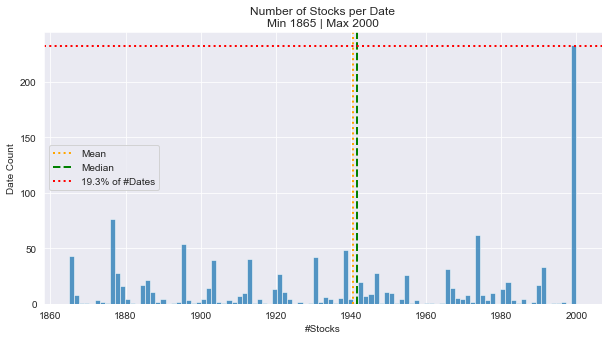

In [16]:
n_stocks_per_date = df_prices.groupby(['Date'])['SecuritiesCode'].count()
date_cnt_max = (n_stocks_per_date == n_stocks_per_date.max()).sum()
date_ratio_max = round(date_cnt_max / len(n_stocks_per_date) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_stocks_per_date.values, bins=100, palette=colors, ax=ax)
ax.axvline(x=n_stocks_per_date.mean(), color='orange', linestyle='dotted',
           linewidth=2, label='Mean')
ax.axvline(x=n_stocks_per_date.median(), color='green', linestyle='--',
           linewidth=2, label='Median')
ax.axhline(y=date_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{date_ratio_max}% of #Dates')
ax.set_title(f"Number of Stocks per Date\nMin {n_stocks_per_date.min()} | "
             f"Max {n_stocks_per_date.max()}")
ax.set_xlabel("#Stocks")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

#### Missing Values

In [17]:
df_no_prices = df_prices[df_prices['Close'].isna()]
print(f"Number of samples without prices: {len(df_no_prices)}")

Number of samples without prices: 7608


On 2020-10-01, the number of stocks without prices reaches its maximum. After further investigation, we discovered that it is due to the failure of the Equity Trading System on October 1, 2020.

In [18]:
no_prices_per_date = df_no_prices['Date'].value_counts().sort_index()
all_dates = sorted(df_prices['Date'].unique())
no_prices_per_date = no_prices_per_date.reindex(all_dates, fill_value=0)

fig = go.Figure()
fig.add_trace(go.Scatter(x=no_prices_per_date.index, 
                         y=no_prices_per_date, 
                         mode='lines'))
rect_focus_params = {
    'xref': 'x', 'yref': 'y', 'x0': '2020-09-25', 'x1': '2020-10-08',
    'y0': 1900, 'y1': 2000, 'line': {'color': 'red', 'width': 1.5}
}
fig.add_shape(type='rect', **rect_focus_params)
fig.update_layout(
    title=f"Number of Stocks without Prices per Date",
    xaxis_title="Date",
    yaxis_title="Stock Count",
)
fig.show()

In [19]:
assert (len(df_prices[df_prices['Date'] == '2020-10-01']) 
        == no_prices_per_date.max())

Over 90% of stocks have only one date with no price information. The leading cause may be one of the indicators earlier, 2020-10-01.

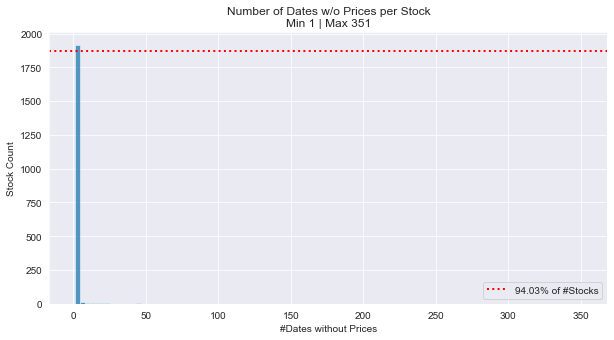

In [20]:
no_prices_per_stock = df_no_prices['SecuritiesCode'].value_counts()
stock_cnt_max = (no_prices_per_stock == no_prices_per_stock.min()).sum()
stock_ratio_max = round(stock_cnt_max / len(no_prices_per_stock) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=no_prices_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% of #Stocks')
ax.set_title(f"Number of Dates w/o Prices per Stock\n"
             f"Min {no_prices_per_stock.min()} | "
             f"Max {no_prices_per_stock.max()}")
ax.set_xlabel("#Dates without Prices")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

#### Target Exploration

Let's look at the target's performance using the OHLCV plot!

In [21]:
def plot_candle_with_target(stock_code, prime=True):
    """Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, code of the stock
        prime: bool, whether the stock to plot is prime or not
    """
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values, 
        'high': df_['High'].values, 
        'low': df_['Low'].values, 
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [22]:
for stock_code in df_prices['SecuritiesCode'].unique()[:5]:
    plot_candle_with_target(stock_code)

A right-skewed distribution is the target mean. It may have a strong kurtosis, with tail data exceeding the normal distribution's tails. For investors, a high kurtosis of the return distribution means that they will see some extreme returns on occasion (either positive or negative). Kurtosis risk is the term for this phenomenon. Outliers should be avoided by rivals. Please see Kurtosis for further information.

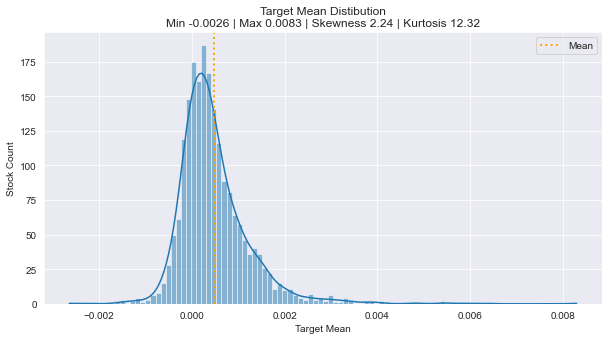

In [23]:
target_mean_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution\n"
             f"Min {round(target_mean_per_stock.min(), 4)} | "
             f"Max {round(target_mean_per_stock.max(), 4)} | "
             f"Skewness {round(target_mean_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Target standard deviation is again a right-skewed distribution, where some of the stocks have higher std (up to 0.06).

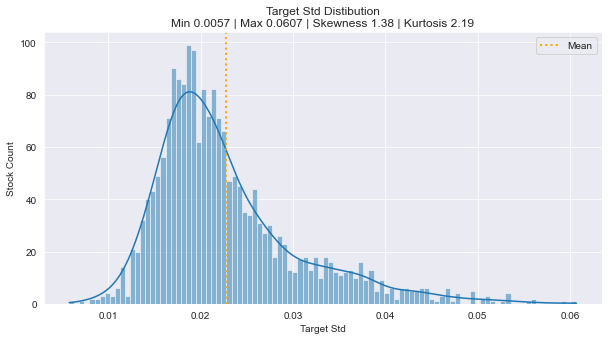

In [24]:
target_std_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].std()
target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution\n"
             f"Min {round(target_std_per_stock.min(), 4)} | "
             f"Max {round(target_std_per_stock.max(), 4)} | "
             f"Skewness {round(target_std_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

The intended mean distribution increases according to the number of dates (i.e., records) in the combined plot of number of dates (i.e., records) per stock. Furthermore, when the number of dates is lower, the target mean dispersion appears to be bigger.

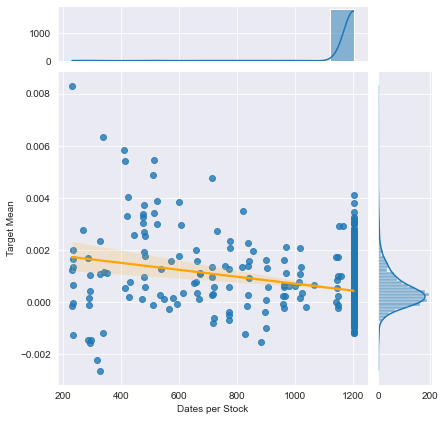

In [25]:
ax = sns.jointplot(x=n_dates_per_stock, y=target_mean_per_stock, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('Dates per Stock')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()

With smaller number of dates per stock, the target value indeed shows greater dispersion (i.e., greater standard deviation).

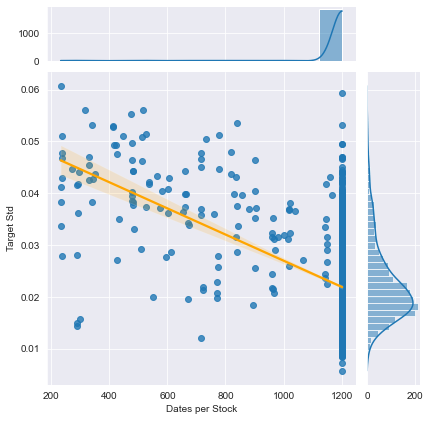

In [26]:
ax = sns.jointplot(x=n_dates_per_stock, y=target_std_per_stock, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('Dates per Stock')
ax.ax_joint.set_ylabel('Target Std')
plt.show()

We know through study that over 90% of stocks have records for the whole training time (namely 1202 records). As a result, the following analysis removes the majority. Furthermore, the conclusion is consistent with the previous data, indicating that a lower number of dates per stock correlates with larger dispersion.

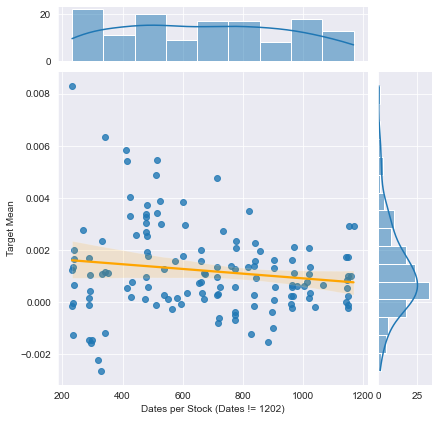

In [27]:
n_dates_per_stock_ = n_dates_per_stock[n_dates_per_stock != 1202]
target_mean_per_stock_ = target_mean_per_stock[target_mean_per_stock.index.isin(n_dates_per_stock_.index)]

ax = sns.jointplot(x=n_dates_per_stock_, y=target_mean_per_stock_, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('Dates per Stock (Dates != 1202)')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()

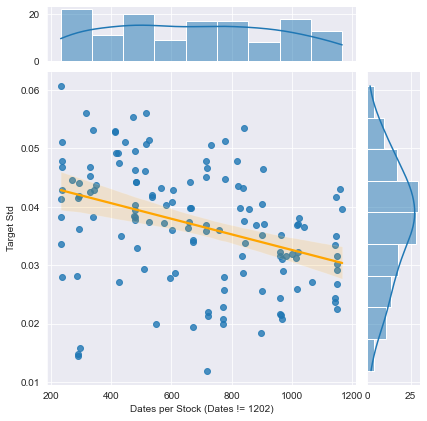

In [28]:
target_std_per_stock_ = target_std_per_stock[target_std_per_stock.index.isin(n_dates_per_stock_.index)]

ax = sns.jointplot(x=n_dates_per_stock_, y=target_std_per_stock_, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('Dates per Stock (Dates != 1202)')
ax.ax_joint.set_ylabel('Target Std')
plt.show()

Enechange Ltd, a Japanese energy switching tool developer, is represented by stock 4169. The data appears to begin on December 23, 2020. The latest IPO information can be found here. Please visit Enechange for additional information.
Another point to note is that the stock with the highest target standard is 4169, thus the study isn't repeated.

In [29]:
tm_max = target_mean_per_stock.max()
stock_tm_max = target_mean_per_stock[target_mean_per_stock == tm_max].index.values[0]

print(f"Stock with max target mean is {stock_tm_max}.")
plot_candle_with_target(stock_tm_max)

Stock with max target mean is 4169.


Let's look at target numbers from the standpoint of time. The target mean distribution is roughly symmetric this time. It does, however, have a significant kurtosis. As a result, outliers should be treated with caution.

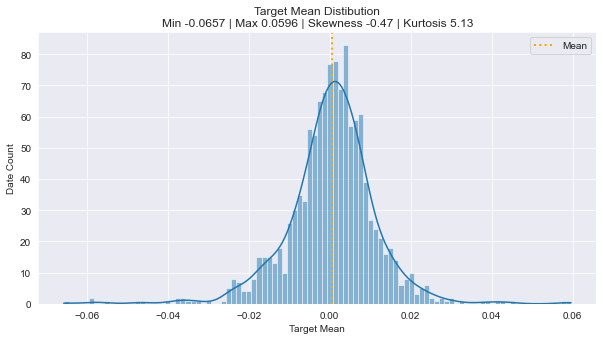

In [30]:
target_mean_per_date = df_prices.groupby(['Date'])['Target'].mean()
target_mean_mean = target_mean_per_date.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_date.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution\n"
             f"Min {round(target_mean_per_date.min(), 4)} | "
             f"Max {round(target_mean_per_date.max(), 4)} | "
             f"Skewness {round(target_mean_per_date.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_date.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

A right-skewed distribution is one in which certain equities have greater standard deviations than others (up to 0.06). The smallest standard is zero, which is fascinating. Let's look at what's going on here.

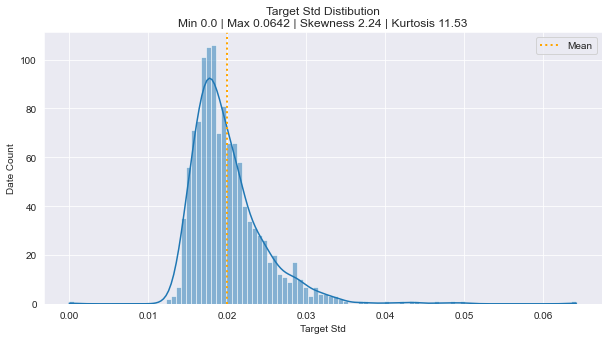

In [31]:
target_std_per_date = df_prices.groupby(['Date'])['Target'].std()
target_std_mean = target_std_per_date.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_date.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution\n"
             f"Min {round(target_std_per_date.min(), 4)} | "
             f"Max {round(target_std_per_date.max(), 4)} | "
             f"Skewness {round(target_std_per_date.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_date.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

We now know why target std will be zero on September 29, 2020. The failure of the trading system on October 1, 2020, as I already stated, is the explanation. Because the prices on the T+2 date are absent. The goal numbers for September 29, 2020 are impossible to calculate.

In [32]:

zero_target_std = target_std_per_date[target_std_per_date == 0].index.values
print(f"The trading dates with zero target std is {zero_target_std}.")

dates_after = df_prices[(df_prices['Date'] >= zero_target_std[0]) & 
                        (df_prices['Date'] < '2020-10-02')]['Date'].unique()
print(f"T+1 trading date of that date is {dates_after[1]}")
print(f"T+2 trading date of that date is {dates_after[2]}")

The trading dates with zero target std is ['2020-09-29'].
T+1 trading date of that date is 2020-09-30
T+2 trading date of that date is 2020-10-01


There are no discernible patterns in the composite plot of the number of stocks per date and the intended mean distribution. However, when the number of stocks per date expands, the dispersion increases slightly.

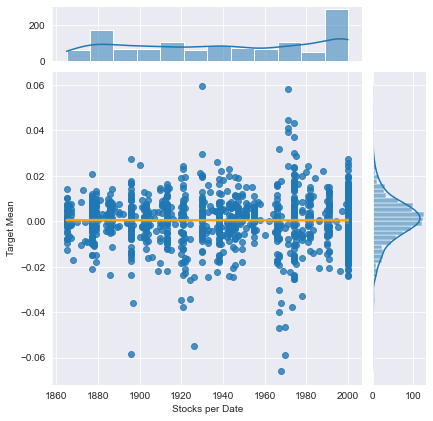

In [33]:
ax = sns.jointplot(x=n_stocks_per_date, y=target_mean_per_date, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('Stocks per Date')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()

A slight increase of dispersion is observed when number of stocks per date becomes larger.

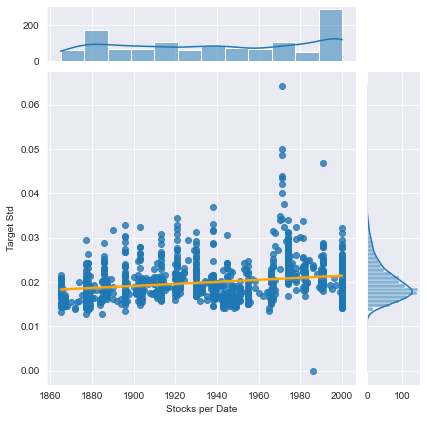

In [34]:
ax = sns.jointplot(x=n_stocks_per_date, y=target_std_per_date, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('Stocks per Date')
ax.ax_joint.set_ylabel('Target Std')
plt.show()

The maximum target mean trading date is December 25, 2018. As a result, we may investigate what occurred on December 27, 2018, the T+2 trading date. After conducting some research, I discovered that the explanation could be the largest point gain in Wall Street history. 

In [35]:
tm_max = target_mean_per_date.max()
date_tm_max = target_mean_per_date[target_mean_per_date == tm_max].index.values[0]
print(f"Date with max target mean is {date_tm_max}.")

Date with max target mean is 2018-12-25.


2020-03-17 is the trading date with the maximum target standard deviation. As a result, we may investigate what occurred on 2020-03-19, the T+2 trading date. The predominance of COVID-19 is the first notion that comes to mind.

In [36]:
ts_max = target_std_per_date.max()
date_ts_max = target_std_per_date[target_std_per_date == ts_max].index.values[0]
print(f"Date with max target std is {date_ts_max}.")

Date with max target std is 2020-03-17.


### 2. Stock_List
#### File Description

The SecuritiesCode is mapped to company names, as well as general information about the company's industry. Column information contained in stock list spec.csv.

In [37]:
summarize(stock_list, "stock_list.csv", n_rows_to_show=2)

=====Summary of stock_list.csv=====
Shape: (4417, 16)
NaN ratio:


NewMarketSegment  TradeDate     Close  IssuedShares  \
NaN Ratio         14.602671   6.701381  6.701381      6.701381   

           MarketCapitalization  SecuritiesCode  EffectiveDate  Name  \
NaN Ratio              6.701381             0.0            0.0   0.0   

           Section/Products  33SectorCode  33SectorName  17SectorCode  \
NaN Ratio               0.0           0.0           0.0           0.0   

           17SectorName  NewIndexSeriesSizeCode  NewIndexSeriesSize  Universe0  
NaN Ratio           0.0                     0.0                 0.0        0.0

SecuritiesCode  EffectiveDate              Name          Section/Products  \
0            1301       20211230  KYOKUYO CO.,LTD.  First Section (Domestic)   
1            1305       20211230   Daiwa ETF-TOPIX                ETFs/ ETNs   

  NewMarketSegment 33SectorCode                       33SectorName  \
0     Prime Market           50  Fishery, Agriculture and Forestry   
1              NaN            -                                  -   

  17SectorCode 17SectorName NewIndexSeriesSizeCode NewIndexSeriesSize  \
0            1       FOODS                       7      TOPIX Small 2   
1            -            -                      -                  -   

    TradeDate   Close  IssuedShares  MarketCapitalization  Universe0  
0  20211230.0  3080.0  1.092828e+07          3.365911e+10       True  
1  20211230.0  2097.0  3.634636e+09          7.621831e+12      False

Universe0 correctly indicates the 2000 target stocks to predict.

In [38]:
assert stock_list['Universe0'].sum() == 2000

First Section (Domestic) dominates Secion/Products of all stocks.

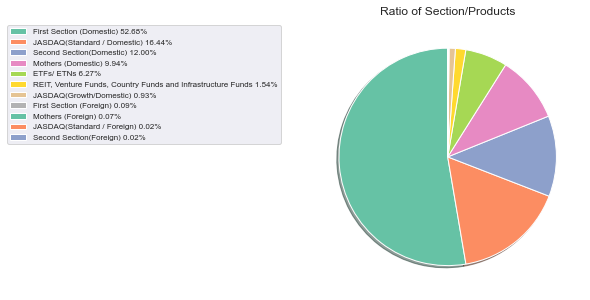

In [39]:
sec_prod_val_cnt = stock_list['Section/Products'].value_counts()
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=colors, 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of Section/Products")
plt.show()

Let's focus on 2000 target stocks. We can find that First Section (Domestic) still dominates Secion/Products of these stocks. And, the 2000 target stocks can be divided into only 5 categories.

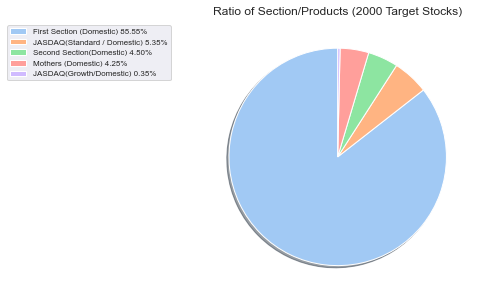

In [40]:
target_stock_list = stock_list[stock_list['Universe0']]
sec_prod_val_cnt = target_stock_list['Section/Products'].value_counts()
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of Section/Products (2000 Target Stocks)")
plt.show()

Stocks in sectors Information & Communication and Services are the majority of the 33 industrial sectors defined by Securities Identification Code Committee (SICC).

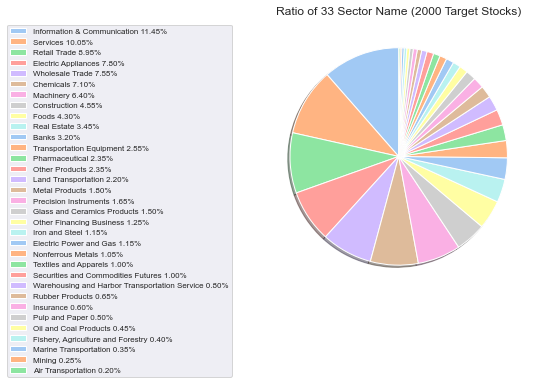

In [41]:
sec_33_val_cnt = target_stock_list['33SectorName'].value_counts()
pct = sec_33_val_cnt / sec_33_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_33_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_33_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of 33 Sector Name (2000 Target Stocks)")
plt.show()

Stocks in series IT & SERVICES, OTHERS are the majority of the TOPIX-17 series defined by Securities Identification Code Committee (SICC). And this category is comprised of stocks in sectors Information & Communication, Services, and Other Products, which can be verified by comparing sector ratios with series ratio.

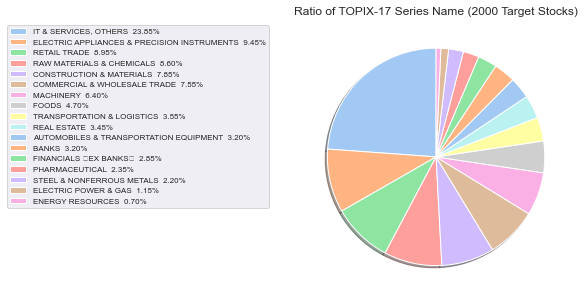

In [42]:
sec_17_val_cnt = target_stock_list['17SectorName'].value_counts()
pct = sec_17_val_cnt / sec_17_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_17_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_17_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of TOPIX-17 Series Name (2000 Target Stocks)")
plt.show()

Let's merge sector information with the stock price DataFrame to do some sector-based analysis.

### 3. Merging the stock_prices & stock_list dataframe

We will focus on the Data describing the stock prices.
That means we will work with the following Datasets:
1. stock_prices.csv
2. stock_list.csv


In [43]:
sec_info = target_stock_list[['SecuritiesCode', '33SectorName', '17SectorName']]
df_prices = pd.merge(df_prices, sec_info, on='SecuritiesCode')
df_prices.head()

RowId        Date  SecuritiesCode    Open    High     Low   Close  \
0  20170104_1301  2017-01-04            1301  2734.0  2755.0  2730.0  2742.0   
1  20170105_1301  2017-01-05            1301  2743.0  2747.0  2735.0  2738.0   
2  20170106_1301  2017-01-06            1301  2734.0  2744.0  2720.0  2740.0   
3  20170110_1301  2017-01-10            1301  2745.0  2754.0  2735.0  2748.0   
4  20170111_1301  2017-01-11            1301  2748.0  2752.0  2737.0  2745.0   

   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag    Target  \
0   31400               1.0               NaN            False  0.000730   
1   17900               1.0               NaN            False  0.002920   
2   19900               1.0               NaN            False -0.001092   
3   24200               1.0               NaN            False -0.005100   
4    9300               1.0               NaN            False -0.003295   

                        33SectorName 17SectorName  
0  Fishery, Agriculture and Forestry       FOODS   
1  Fishery, Agriculture and Forestry       FOODS   
2  Fishery, Agriculture and Forestry       FOODS   
3  Fishery, Agriculture and Forestry       FOODS   
4  Fishery, Agriculture and Forestry       FOODS

In [44]:
# For local 
df = pd.read_csv('../data/train_files/stock_prices.csv',
                 parse_dates=['Date'])\
        .drop('RowId', axis= 1).merge(
            pd.read_csv('../data/stock_list.csv')[['SecuritiesCode', 'Name', '33SectorName', '17SectorName', 'IssuedShares', 'MarketCapitalization']],
            on = 'SecuritiesCode', how = 'left')

df.set_index('Date', inplace= True)

df.head()

SecuritiesCode    Open    High     Low   Close   Volume  \
Date                                                                  
2017-01-04            1301  2734.0  2755.0  2730.0  2742.0    31400   
2017-01-04            1332   568.0   576.0   563.0   571.0  2798500   
2017-01-04            1333  3150.0  3210.0  3140.0  3210.0   270800   
2017-01-04            1376  1510.0  1550.0  1510.0  1550.0    11300   
2017-01-04            1377  3270.0  3350.0  3270.0  3330.0   150800   

            AdjustmentFactor  ExpectedDividend  SupervisionFlag    Target  \
Date                                                                        
2017-01-04               1.0               NaN            False  0.000730   
2017-01-04               1.0               NaN            False  0.012324   
2017-01-04               1.0               NaN            False  0.006154   
2017-01-04               1.0               NaN            False  0.011053   
2017-01-04               1.0               NaN            False  0.003026   

                                  Name                       33SectorName  \
Date                                                                        
2017-01-04            KYOKUYO CO.,LTD.  Fishery, Agriculture and Forestry   
2017-01-04   Nippon Suisan Kaisha,Ltd.  Fishery, Agriculture and Forestry   
2017-01-04  Maruha Nichiro Corporation  Fishery, Agriculture and Forestry   
2017-01-04       KANEKO SEEDS CO.,LTD.  Fishery, Agriculture and Forestry   
2017-01-04     SAKATA SEED CORPORATION  Fishery, Agriculture and Forestry   

           17SectorName  IssuedShares  MarketCapitalization  
Date                                                         
2017-01-04       FOODS     10928283.0          3.365911e+10  
2017-01-04       FOODS    312430277.0          1.696496e+11  
2017-01-04       FOODS     52656910.0          1.266399e+11  
2017-01-04       FOODS     11772626.0          1.770603e+10  
2017-01-04       FOODS     47410750.0          1.557443e+11

In [45]:
# for google colab
#df = pd.read_csv('/content/drive/MyDrive/JPX_Tokyo_Stock_Exchange_Prediction/data/train_files/stock_prices.csv',
                 #parse_dates=['Date'])\
        #.drop('RowId', axis= 1).merge(
            #pd.read_csv('/content/drive/MyDrive/JPX_Tokyo_Stock_Exchange_Prediction/data/train_files/stock_list.csv')[['SecuritiesCode', 'Name', '33SectorName', '17SectorName', 'IssuedShares', 'MarketCapitalization']],
            #on = 'SecuritiesCode', how = 'left')

#df.set_index('Date', inplace= True)

#df.head()

Over the training time, we can see that Marine Transportation has the highest goal mean, followed by Information & Communication and Services. Banks are the only industry with a negative goal mean.

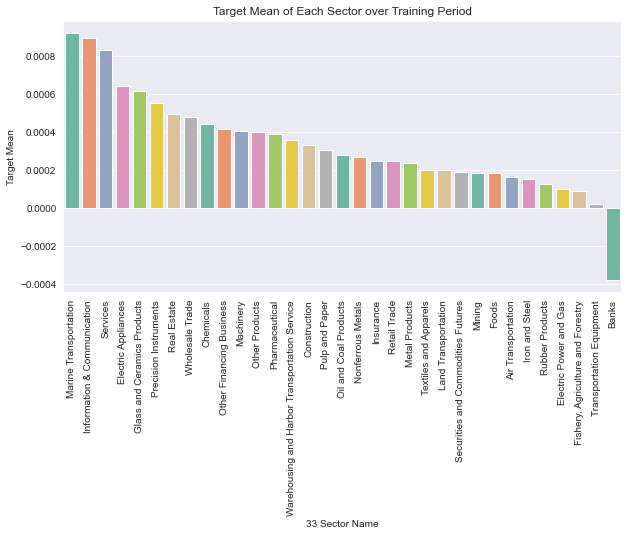

In [46]:
target_mean_33sec = df.groupby(['33SectorName'])['Target'].mean()
target_mean_33sec.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_33sec.index, y=target_mean_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Target Mean of Each Sector over Training Period")
ax.set_xlabel("33 Sector Name")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Mean")
plt.show()

As for target dispersion, Information & Communication has the highest target std over the training period, followed by Services and Pharmaceutical. And, Fishery, Agriculture and Forestry has the lowest.

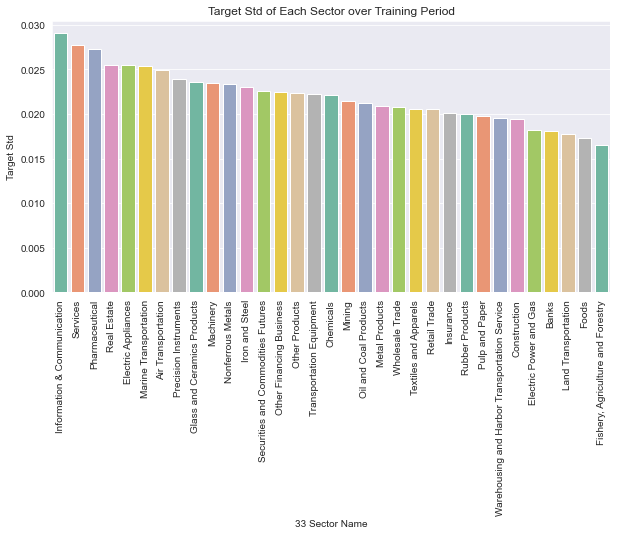

In [47]:
target_std_33sec = df.groupby(['33SectorName'])['Target'].std()
target_std_33sec.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_std_33sec.index, y=target_std_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Target Std of Each Sector over Training Period")
ax.set_xlabel("33 Sector Name")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Std")
plt.show()

Let's step into the sector with the highest target mean, Marine Transportation. Stocks with top3 target mean are Nippon Yusen K.K. (9101), Kawasaki Kisen Kaisha, Ltd. (9107), and Mitsui OSK Lines, Ltd. (9104). 

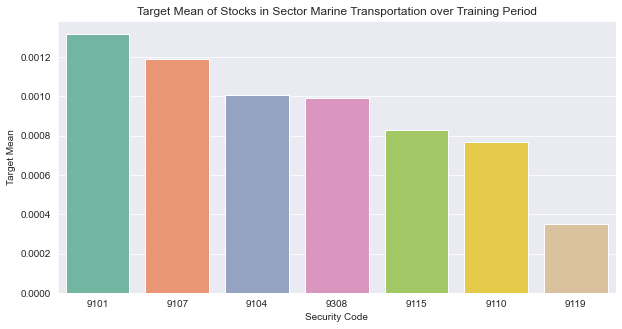

In [48]:
target_sector = 'Marine Transportation'
df_prices_marine = df[df['33SectorName'] == target_sector]
target_mean_marine = df_prices_marine.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_marine.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_marine.index, y=target_mean_marine.values, 
            order=target_mean_marine.index, palette=colors, ax=ax)
ax.set_title("Target Mean of Stocks in Sector Marine Transportation over Training Period")
ax.set_xlabel("Security Code")
ax.set_ylabel("Target Mean")
plt.show()

Interpreting target series on daily scale, we can find that stocks within the same sector have a strong spatial dependency. That is, the target series move in sync.

In [49]:
unique_dates = sorted(df_prices['Date'].unique())

fig = go.Figure()
for stock_code in [9101, 9107, 9104]:
    df_ = df_prices_marine[df_prices_marine['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 3 Best Stocks in Marine Transportation",
)
fig.show()

Let's see how target series of stocks in the worst sector, Bank, behave over the training period. As we can see, the behavior is significantly different from that of the best sector, Marine Transportation. Only five of the stocks have positive target means. And, Suruga Bank Ltd. (8358) has the worst performance on average. 

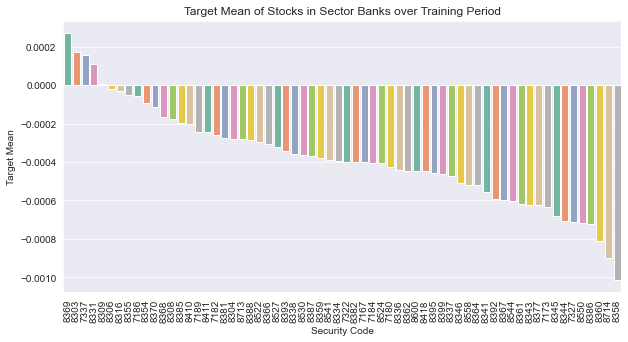

In [50]:
target_sector = 'Banks'
df_prices_banks = df[df['33SectorName'] == target_sector]
target_mean_banks = df_prices_banks.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_banks.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_banks.index, y=target_mean_banks.values, 
            order=target_mean_banks.index, palette=colors, ax=ax)
ax.set_title("Target Mean of Stocks in Sector Banks over Training Period")
ax.set_xlabel("Security Code")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Mean")
plt.show()

Again, let's observe target series on daily scale. Stocks within the same sector have some interrelationship with each other. That is, the target series move in sync.

In [51]:
fig = go.Figure()
for stock_code in [8360, 8714, 8358]:
    df_ = df_prices_banks[df_prices_banks['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 3 Worst Stocks in Banks",
)
fig.show()

Let's verify if stocks from different sectors have the relationship observed above. I select stocks 9101, 9104, 8714 and 8358 to illustrate the statement. Apparently, target series from different sectors have weaker spatial dependency compared with those from the same sector.

In [52]:
fig = go.Figure()
for stock_code in [9101, 9104, 8714, 8358]:
    df_ = df_prices[df_prices['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 2 Best Stocks in Marine Transportation and 2 Worst in Banks",
)
fig.show()

### 4. Secondary Stocks
#### File Description

This file contains statistics on stocks with low liquidity, which means there are few trading possibilities. Stock prices.csv has the same column information.

#### Summary
Secondary stock prices.csv has a larger number of records than stock prices.csv. Furthermore, the missing issue appears to be more serious. Secondary stocks, as we all know, have little liquidity, which may reduce the amount of records. Let's wait and see what occurs.

In [53]:
summarize(df_prices_sec, "secondary_stock_prices.csv")

=====Summary of secondary_stock_prices.csv=====
Shape: (2384575, 12)
NaN ratio:


ExpectedDividend      Open      High       Low     Close   Target  \
NaN Ratio         99.225942  3.847688  3.847688  3.847688  3.847688  0.03011   

           RowId  Date  SecuritiesCode  Volume  AdjustmentFactor  \
NaN Ratio    0.0   0.0             0.0     0.0               0.0   

           SupervisionFlag  
NaN Ratio              0.0

RowId        Date  SecuritiesCode     Open     High      Low  \
0  20170104_1305  2017-01-04            1305   1594.0   1618.0   1594.0   
1  20170104_1306  2017-01-04            1306   1575.0   1595.0   1573.0   
2  20170104_1308  2017-01-04            1308   1557.0   1580.0   1557.0   
3  20170104_1309  2017-01-04            1309  28810.0  29000.0  28520.0   
4  20170104_1311  2017-01-04            1311    717.0    735.0    717.0   

     Close   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
0   1615.0   538190               1.0               NaN            False   
1   1593.0  2494980               1.0               NaN            False   
2   1578.0   526100               1.0               NaN            False   
3  28780.0      403               1.0               NaN            False   
4    734.0     5470               1.0               NaN            False   

     Target  
0 -0.001855  
1 -0.000627  
2 -0.001900  
3  0.005237  
4  0.001359

In [54]:
row_id = (df_prices_sec['Date'].apply(lambda date: ''.join(date.split('-'))+'_')
          + df_prices_sec['SecuritiesCode'].astype(str))
assert (df_prices_sec['RowId'] == row_id).all()

Now we can see why number of records in secondary_stock_prices.csv is more than that in stock_prices.csv. Number of secondary stocks is 2371, more than number of prime stocks which is 2000. Also, the unqiue number of dates is the same over training period.

In [55]:
n_dates = df_prices_sec['Date'].nunique()
date_min, date_max = df_prices_sec['Date'].min(), df_prices['Date'].max()
n_stocks = df_prices_sec['SecuritiesCode'].nunique()

print(f"Number of unique dates: {n_dates} ({date_min} ~ {date_max})\n"
      f"Number of unique secondary stocks: {n_stocks}")

Number of unique dates: 1202 (2017-01-04 ~ 2021-12-03)
Number of unique secondary stocks: 2371


Target mean distribution behaves exactly different from that of prime stocks. The extremely large kurtosis indicates that investing in secondary stocks might be riskier.

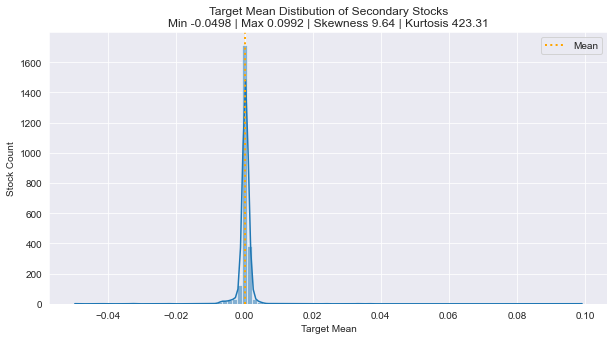

In [56]:
target_mean_per_stock = df_prices_sec.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution of Secondary Stocks\n"
             f"Min {round(target_mean_per_stock.min(), 4)} | "
             f"Max {round(target_mean_per_stock.max(), 4)} | "
             f"Skewness {round(target_mean_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Target standard deviation has a long right tail, and the stock with the highest dispersion has target std up to 0.3.

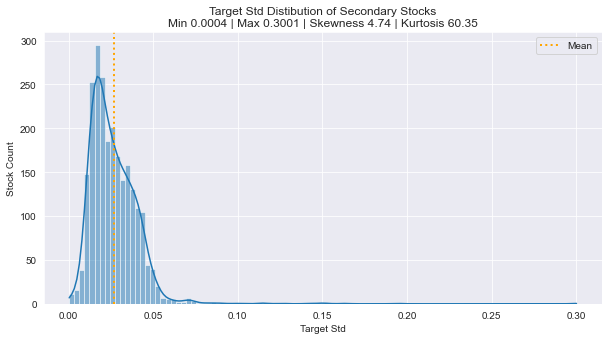

In [57]:
target_std_per_stock = df_prices_sec.groupby(['SecuritiesCode'])['Target'].std()
target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution of Secondary Stocks\n"
             f"Min {round(target_std_per_stock.min(), 4)} | "
             f"Max {round(target_std_per_stock.max(), 4)} | "
             f"Skewness {round(target_std_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Because secondary companies have fewer trading chances, OHLCV graphs reveal interesting trends. However, some stocks (e.g., Science Arts, Inc. (4412) and Last One Mile Co.,Ltd. (9252) mentioned below) launch an IPO at the end of the training period, resulting in a shortage of records in the training set. 

In [58]:
target_mean_per_stock.sort_values(inplace=True, ascending=False)
target_std_per_stock.sort_values(inplace=True, ascending=False)
stock_with_max_tm = target_mean_per_stock.index[0]
stock_with_min_tm = target_mean_per_stock.index[-1]
stock_with_max_ts = target_std_per_stock.index[0]
stock_with_min_ts = target_std_per_stock.index[-1]

print(f"The secondary stock with the max target mean is {stock_with_max_tm},"
      f" and min is {stock_with_min_tm}.")
print(f"The secondary stock with the max target std is {stock_with_max_ts},"
      f" and min is {stock_with_min_ts}.")

The secondary stock with the max target mean is 4412, and min is 9252.
The secondary stock with the max target std is 1689, and min is 8728.


In [59]:
for stock_code in [4412, 9252, 1689, 8728]:
    plot_candle_with_target(stock_code, prime=False)

### 5. Trade
#### File Description

Aggregated summary of trading volumes from the previous business week. Following is column information recorded in trades_spec.csv:

* Date: Data published date, usually Thursday on the following week.
* StartDate: The first trading date in this trading week.
* EndDate: The last trading date in this trading week.
* Section: Market division name.



In [60]:
summarize(df_trades, 'trades.csv')

=====Summary of trades.csv=====
Shape: (1712, 56)
NaN ratio:


InvestmentTrustsSales  StartDate  InvestmentTrustsTotal  \
NaN Ratio              55.315421  55.315421              55.315421   

           InvestmentTrustsBalance  BusinessCosSales  BusinessCosPurchases  \
NaN Ratio                55.315421         55.315421             55.315421   

           BusinessCosTotal  BusinessCosBalance  OtherInstitutionsSales  \
NaN Ratio         55.315421           55.315421               55.315421   

           OtherInstitutionsPurchases  ...  IndividualsPurchases  \
NaN Ratio                   55.315421  ...             55.315421   

           IndividualsTotal  IndividualsBalance  ForeignersSales  \
NaN Ratio         55.315421           55.315421        55.315421   

           ForeignersPurchases  ForeignersTotal  ForeignersBalance  \
NaN Ratio            55.315421        55.315421          55.315421   

           SecuritiesCosSales  SecuritiesCosPurchases  Date  
NaN Ratio           55.315421               55.315421   0.0  

[1 rows x 56 columns]

Date StartDate EndDate Section  TotalSales  TotalPurchases  \
0  2017-01-04       NaN     NaN     NaN         NaN             NaN   
1  2017-01-05       NaN     NaN     NaN         NaN             NaN   
2  2017-01-06       NaN     NaN     NaN         NaN             NaN   
3  2017-01-10       NaN     NaN     NaN         NaN             NaN   
4  2017-01-11       NaN     NaN     NaN         NaN             NaN   

   TotalTotal  TotalBalance  ProprietarySales  ProprietaryPurchases  ...  \
0         NaN           NaN               NaN                   NaN  ...   
1         NaN           NaN               NaN                   NaN  ...   
2         NaN           NaN               NaN                   NaN  ...   
3         NaN           NaN               NaN                   NaN  ...   
4         NaN           NaN               NaN                   NaN  ...   

   CityBKsRegionalBKsEtcTotal  CityBKsRegionalBKsEtcBalance  TrustBanksSales  \
0                         NaN                           NaN              NaN   
1                         NaN                           NaN              NaN   
2                         NaN                           NaN              NaN   
3                         NaN                           NaN              NaN   
4                         NaN                           NaN              NaN   

   TrustBanksPurchases  TrustBanksTotal  TrustBanksBalance  \
0                  NaN              NaN                NaN   
1                  NaN              NaN                NaN   
2                  NaN              NaN                NaN   
3                  NaN              NaN                NaN   
4                  NaN              NaN                NaN   

   OtherFinancialInstitutionsSales  OtherFinancialInstitutionsPurchases  \
0                              NaN                                  NaN   
1                              NaN                                  NaN   
2                              NaN                                  NaN   
3                              NaN                                  NaN   
4                              NaN                                  NaN   

   OtherFinancialInstitutionsTotal  OtherFinancialInstitutionsBalance  
0                              NaN                                NaN  
1                              NaN                                NaN  
2                              NaN                                NaN  
3                              NaN                                NaN  
4                              NaN                                NaN  

[5 rows x 56 columns]

#### *Simple Summary*
As we can see, NaN ratio is the same (*i.e.*, $55.315421$) for all columns. Let's drop all rows with NaNs and do furthur analysis.

In [61]:
nan_cnt = df_trades.isna().sum().max()
df_trades.dropna(inplace=True)
assert len(df_trades) == 1712 - nan_cnt

#### 6. Section
Every business week has the information from three sections, Growth Market (Mothers/JASDAQ), Prime Market (First Section), and Standard Market (Second Section).

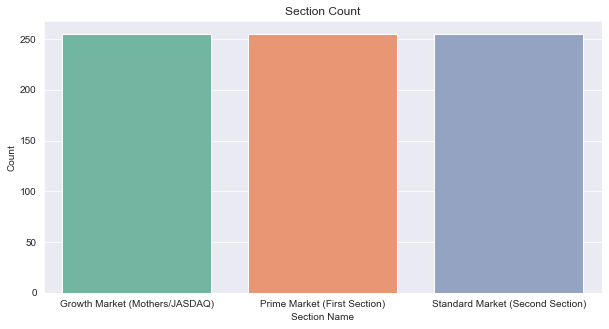

In [62]:
section_cnt = df_trades['Section'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=section_cnt.index, y=section_cnt.values,  palette=colors, ax=ax)
ax.set_title("Section Count")
ax.set_xlabel("Section Name")
ax.set_ylabel("Count")
plt.show()

Section-specific series show that the business activity in prime market is more vigorous than the others. Following are just two examples for illustration.

In [63]:
def show_ts_in_diff_sec(feat_name):
    """Plot time series of the given feature in different sections.
    
    Parameters:
        feat_name: str, feature name 
    """
    fig = px.line(df_trades, x='EndDate', y=feat_name, color='Section', 
                  symbol='Section')
    fig.update_layout(
        title=f"{feat_name} Series",
    )
    fig.show()

In [64]:
for feat in ['TotalSales', 'TotalPurchases']:
    show_ts_in_diff_sec(feat)

### 7. Options

Based on the broader market, information on the status of a variety of options. Even though many options are not assessed directly, they may be of importance because they offer implicit projections of future stock market prices. Column information contained in options spec.csv is as follows:

* `DateCode`: Unique ID for option price records, the combination of `Date` and `OptionCode`. 
* `Date`: Trade date and time.
* `OptionsCode`: Local securities code. 
* `WholeDayOpen`: Opening price for whole trading day.
* `WholeDayHigh`: Highest price for whole trading day.
* `WholeDayLow`: Lowest price for whole trading day.
* `WholeDayClose`: Closing price for whole trading day.
* `NightSessionOpen`: Opening price for night session.
* `NightSessionHigh`: Highest price for night session.
* `NightSessionLow`: Lowest price for night session.
* `NightSessionClose`: Closing price for night session.
* `DaySessionOpen`: Opening price for day session.
* `DaySessionHigh`: Highest price for day session.
* `DaySessionLow`: Lowest price for day session.
* `DaySessionClose`: Closing price for day session.
* `TradingVolume`: Trading volume of the product/contract for the whole trading day.
* `OpenInterest`: Open interest of the product/contract for the whole trading day
* `TradingValue`: Trading value of the product/contract for the whole trading day
* `ContractMonth`: Contract year-month of the product/contract.
* `StrikePrice`: Exercise price of product/contract.
* `DaySessionVolume`: Trading volume of the product/contract for day session.
* `Putcall`: 1 for put and 2 for call.
* `LastTradingDay`: Last trading day.
* `SpecialQuotationDay`: The day when the Special Quotation is calculated.
* `SettlementPrice`: Settlement price.
* `TheoreticalPrice`: The theoretical price at the end of a day session.
* `BaseVolatility`: The volatility at the time of calculating the settlement price.
* `ImpliedVolatility`: Implied volatility.
* `InterestRate`: Interest rate for calculation.
* `DividendRate`: Dividend yield.
* `Dividend`: Dividend.



In [65]:
summarize(df_opts, 'options.csv')

=====Summary of options.csv=====
Shape: (3567694, 31)
NaN ratio:


DateCode  OpenInterest  DividendRate  InterestRate  \
NaN Ratio       0.0           0.0           0.0           0.0   

           ImpliedVolatility  BaseVolatility  TheoreticalPrice  \
NaN Ratio                0.0             0.0               0.0   

           SettlementPrice  SpecialQuotationDay  LastTradingDay  ...  \
NaN Ratio              0.0                  0.0             0.0  ...   

           NightSessionClose  NightSessionLow  NightSessionHigh  \
NaN Ratio                0.0              0.0               0.0   

           NightSessionOpen  WholeDayClose  WholeDayLow  WholeDayHigh  \
NaN Ratio               0.0            0.0          0.0           0.0   

           WholeDayOpen  OptionsCode  Dividend  
NaN Ratio           0.0          0.0       0.0  

[1 rows x 31 columns]

DateCode        Date  OptionsCode  WholeDayOpen  WholeDayHigh  \
0  20170104_132010018  2017-01-04    132010018         650.0         650.0   
1  20170104_132010118  2017-01-04    132010118           0.0           0.0   
2  20170104_132010218  2017-01-04    132010218           0.0           0.0   
3  20170104_132010318  2017-01-04    132010318           0.0           0.0   
4  20170104_132010518  2017-01-04    132010518           0.0           0.0   

   WholeDayLow  WholeDayClose NightSessionOpen NightSessionHigh  \
0        480.0          480.0           0.0000           0.0000   
1          0.0            0.0           0.0000           0.0000   
2          0.0            0.0           0.0000           0.0000   
3          0.0            0.0           0.0000           0.0000   
4          0.0            0.0           0.0000           0.0000   

  NightSessionLow  ... Putcall  LastTradingDay  SpecialQuotationDay  \
0          0.0000  ...       1        20170112             20170113   
1          0.0000  ...       1        20170112             20170113   
2          0.0000  ...       1        20170112             20170113   
3          0.0000  ...       1        20170112             20170113   
4          0.0000  ...       1        20170112             20170113   

   SettlementPrice  TheoreticalPrice  BaseVolatility  ImpliedVolatility  \
0            480.0          478.4587         17.4736            17.5865   
1            575.0          571.1385         17.4736            16.5000   
2            680.0          677.3710         17.4736            15.8644   
3            795.0          791.0383         17.4736            15.2288   
4            910.0          909.9947         17.4736            14.5932   

   InterestRate  DividendRate  Dividend  
0        0.0091           0.0       0.0  
1        0.0091           0.0       0.0  
2        0.0091           0.0       0.0  
3        0.0091           0.0       0.0  
4        0.0091           0.0       0.0  

[5 rows x 31 columns]

#### key

DateCode is composed of Date and OptionsCode. Training period is exactly the same as that of stocks. But, number of types of options is larger than number of prime stocks (secondary excluded).

In [66]:
date_code = (df_opts['Date'].apply(lambda date: ''.join(date.split('-'))+'_')
             + df_opts['OptionsCode'].astype(str))
assert (df_opts['DateCode'] == date_code).all()

In [67]:
n_dates = df_opts['Date'].nunique()
date_min, date_max = df_opts['Date'].min(), df_opts['Date'].max()
n_opts = df_opts['OptionsCode'].nunique()

print(f"Number of unique dates: {n_dates} ({date_min} ~ {date_max})\n"
      f"Number of unique options: {n_opts}")

Number of unique dates: 1202 (2017-01-04 ~ 2021-12-03)
Number of unique options: 14732


Let's look at the number of samples from the Date and OptionsCode perspectives, just like we did with stock prices.
This time, a strange pattern is discovered. There are certain alternatives that have more dates than there are unique dates (1202). Let's see if there are any duplicate rows.

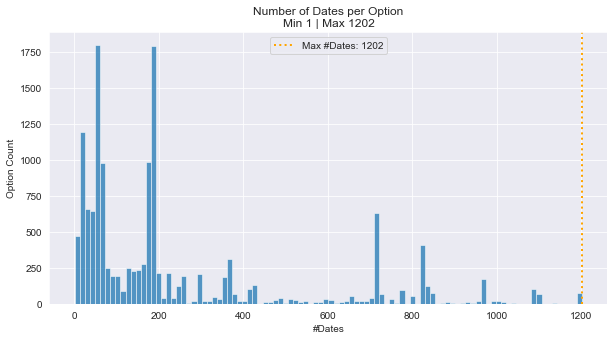

In [68]:
n_dates_per_opt = df_opts.groupby(['OptionsCode'])['Date'].count()
n_dates_per_opt_max = n_dates_per_opt.max()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_dates_per_opt.values, bins=100, palette=colors, ax=ax)
ax.axvline(x=n_dates_per_opt_max, color='orange', linestyle='dotted', linewidth=2,
           label=f'Max #Dates: {n_dates_per_opt_max}')
ax.set_title(f"Number of Dates per Option\nMin {n_dates_per_opt.min()} | "
             f"Max {n_dates_per_opt_max}")
ax.set_xlabel("#Dates")
ax.set_ylabel("Option Count")
ax.legend()
plt.show()

Due to the diversity of options, number of options per date has a greater dispersion than that of prime stocks.

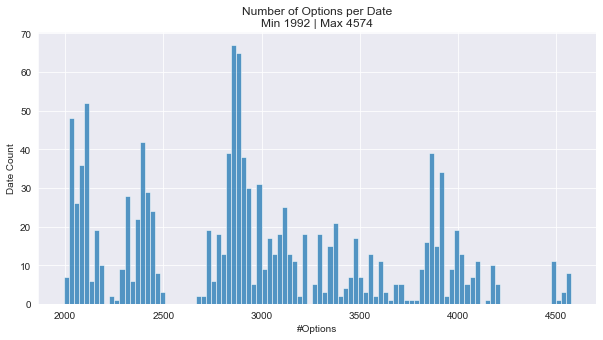

In [69]:
n_opts_per_date = df_opts.groupby(['Date'])['OptionsCode'].count()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_opts_per_date.values, bins=100, palette=colors, ax=ax)
ax.set_title(f"Number of Options per Date\nMin {n_opts_per_date.min()} | "
             f"Max {n_opts_per_date.max()}")
ax.set_xlabel("#Options")
ax.set_ylabel("Date Count")
plt.show()

#### Zero Values

All values in column Dividend are zeros; hence, we can direcly drop that column. Also, zeros appear more frequently in day session than night.

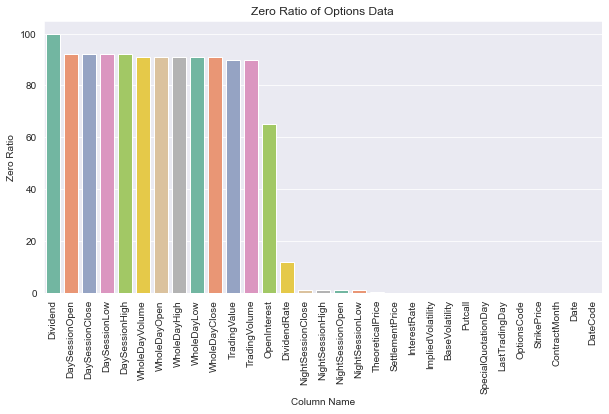

In [70]:
zero_ratio = (df_opts == 0).sum() / len(df_opts) * 100
zero_ratio.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=zero_ratio.index, y=zero_ratio.values, palette=colors, ax=ax)
ax.set_title("Zero Ratio of Options Data")
ax.set_xlabel("Column Name")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Zero Ratio")
plt.show()

#### 8. Option Code

#### *Composition*

Figure above shows the composition of `OptionsCode`. Some observations are summarized as follows:

+ All derivatives are **special transactions** (*i.e.*, the first digit is 1).
+ All derivatives are **options transaction on spot**.
+ Contract year code works fine.
+ The only underlying index taken into consideration is **Nikkei Stock Average (Nikkei 225)** coded as **18**.

In [71]:
opts = df_opts['OptionsCode'].unique()
print(f"Number of unique options: {len(opts)}")

Number of unique options: 14732


#### Special transaction
All derivatives are **special transactions**, whose first digits are set to 1.

In [72]:
assert np.sum((opts // 1e8) == 0) == 0

#### Derivative classification
All derivatives are **options transaction on spot**, and no **futures** is involved. The derivative class meaning is as follows:
* `3` and `8`: **Put** options transaction (spot).
* `4` and `9`: **Call** options transaction (spot).

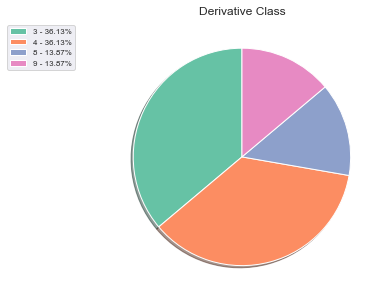

In [73]:
deriv_class, deriv_val_cnt = np.unique(opts % 1e8 // 1e7, return_counts=True)
pct = deriv_val_cnt / np.sum(deriv_val_cnt) * 100
labels = [f"{int(c)} - {ratio:.2f}%" for c, ratio in zip(deriv_class, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(deriv_val_cnt, 
                        colors=colors, 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, deriv_val_cnt),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Derivative Class")
plt.show()

#### Contract month

**Contract year** works fine for each options.

In [74]:
# Convert contract year to 10-year cycle code
year2code = lambda y: ((y%10) + 5) % 10

In [75]:
df_opts_exp = df_opts[['OptionsCode', 'ContractMonth']]
df_opts_exp['ContractMonth'] = pd.to_datetime(df_opts_exp['ContractMonth'],
                                              format="%Y%m")
df_opts_exp['ExpYear'] = df_opts_exp['ContractMonth'].dt.year
df_opts_exp['ExpMonth'] = df_opts_exp['ContractMonth'].dt.month
df_opts_exp['ExpYearCode'] = df_opts_exp['ExpYear'].apply(year2code)
df_opts_exp.drop(['ContractMonth'], inplace=True, axis=1)

df_opts_exp.head()

OptionsCode  ExpYear  ExpMonth  ExpYearCode
0    132010018     2017         1            2
1    132010118     2017         1            2
2    132010218     2017         1            2
3    132010318     2017         1            2
4    132010518     2017         1            2

In [76]:
assert ((df_opts_exp['OptionsCode'] % 1e7 // 1e6) 
        != df_opts_exp['ExpYearCode']).any() == 0

#### Exercise price
Exercise price (strike price) is coded as a 2-digit number. As we can see in **(5) Underlying index** below, the underlying index is always **Nikkei Stock Average (Nikkei 225)**, whose intervals between exercise prices is **JPY 250**.

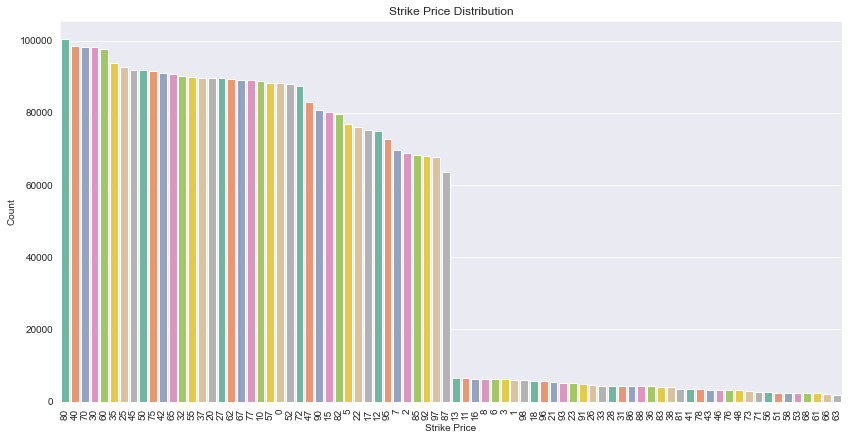

In [77]:
exp_prices = (df_opts['OptionsCode'] % 1e4 // 1e2).value_counts()

fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x=exp_prices.index.astype(int), y=exp_prices.values, 
            order=exp_prices.index.astype(int), palette=colors, ax=ax)
ax.set_title("Strike Price Distribution")
ax.set_xlabel("Strike Price")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Count")
plt.show()

#### Underlying index
Only **Nikkei Stock Average (Nikkei 225)** is taken into consideration in `options.csv`.

In [78]:
df_opts['UnderlyingIndex'] = (df_opts['OptionsCode'] % 1e2).astype(np.int8)
unique_underlying = df_opts['UnderlyingIndex'].unique()

print(f"Number of underlying index: {len(unique_underlying)}\n"
      f"Their codes are {unique_underlying}")

Number of underlying index: 1
Their codes are [18]


## JPX Tokyo Stock Market

Lets focus on the stock_price & stock_list dataset for further insight into the stock market

HTML(value='<h3>Top Gaining Targets</h3>')


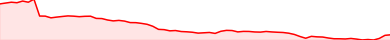
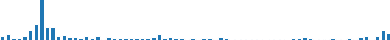
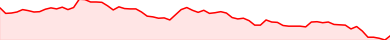
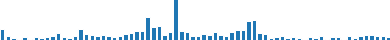
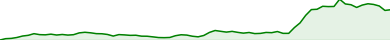
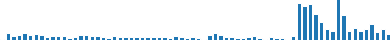
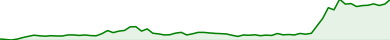
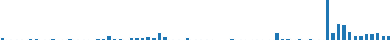
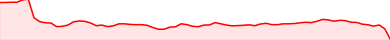
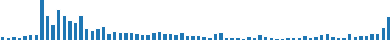
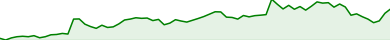
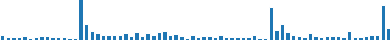
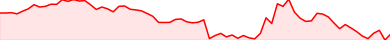
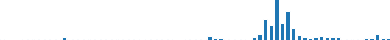
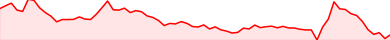
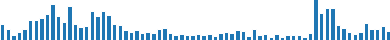
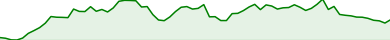
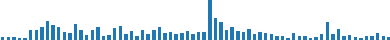
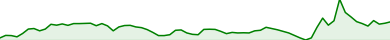
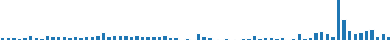

HTML(value='<h3>Top Loosing Targets</h3>')


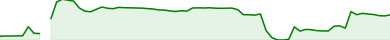
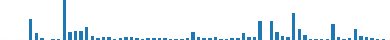
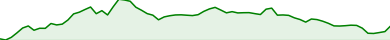
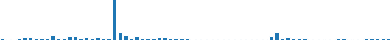
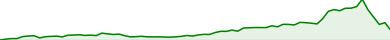
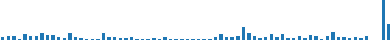
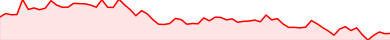
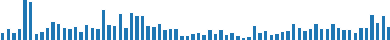
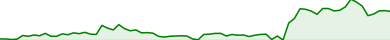
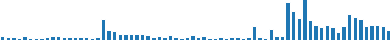
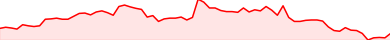
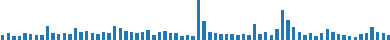
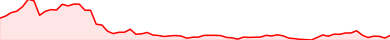
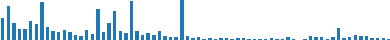
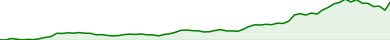
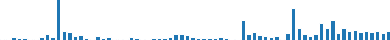
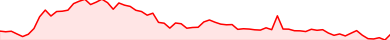
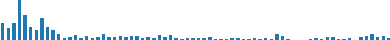
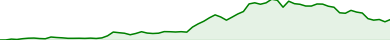
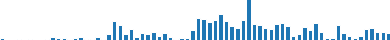

In [79]:
def show_table(df= df, date= '2021-12-03', sort_by= 'Target', asc= False, num_of_rows=10):
    
    # get data in between the date range
    a = df[df.index.isin(np.sort(df.index[df.index <= '2021-12-03'].unique())[-70:])]\
        .groupby('SecuritiesCode').agg(
            Name= pd.NamedAgg(column= 'Name', aggfunc='last'),
            Close= pd.NamedAgg('Close','last'),
            Target= pd.NamedAgg('Target', 'last'),
            Close_list= pd.NamedAgg('Close', pd.Series.tolist),
            Volume_list= pd.NamedAgg('Volume', pd.Series.tolist))\
        .sort_values(sort_by, ascending= asc).iloc[:num_of_rows]
    
    # add close line chart
    a['70_D_Close'] = a['Close_list'].apply(sparkline)
    
    # add volume bar chart
    a['70_D_Volume'] = a['Volume_list'].apply(lambda x: sparkline(x, isBar=True))
    
    
    return display(
        a[['Name', '70_D_Close', 'Close', '70_D_Volume', 'Target']]\
            .style.bar(subset=['Target'], align= 'zero', color= '#C0C0C0')\
            .set_properties(subset=['70_D_Close', '70_D_Volume'], **{'width': '250px'})\
            .set_properties(subset=['Name'], **{'width': '200px'})\
            .format('{:.2f}', subset= ['Close', 'Target']))


display(HTML('<h3>Top Gaining Targets</h3>'))
show_table(asc= False)

display(HTML('<h3>Top Loosing Targets</h3>'))
show_table(asc= True)

#### Sectors
Below we can See a crisp summary of sector-wise action happening across

* Target
* Turover: (close* volume) Volume measures the number of shares traded in a stock. Volume can indicate market strength.
* Market Capitalization: Market capitalization, commonly called market cap, is the market value of a publicly traded company's outstanding shares.

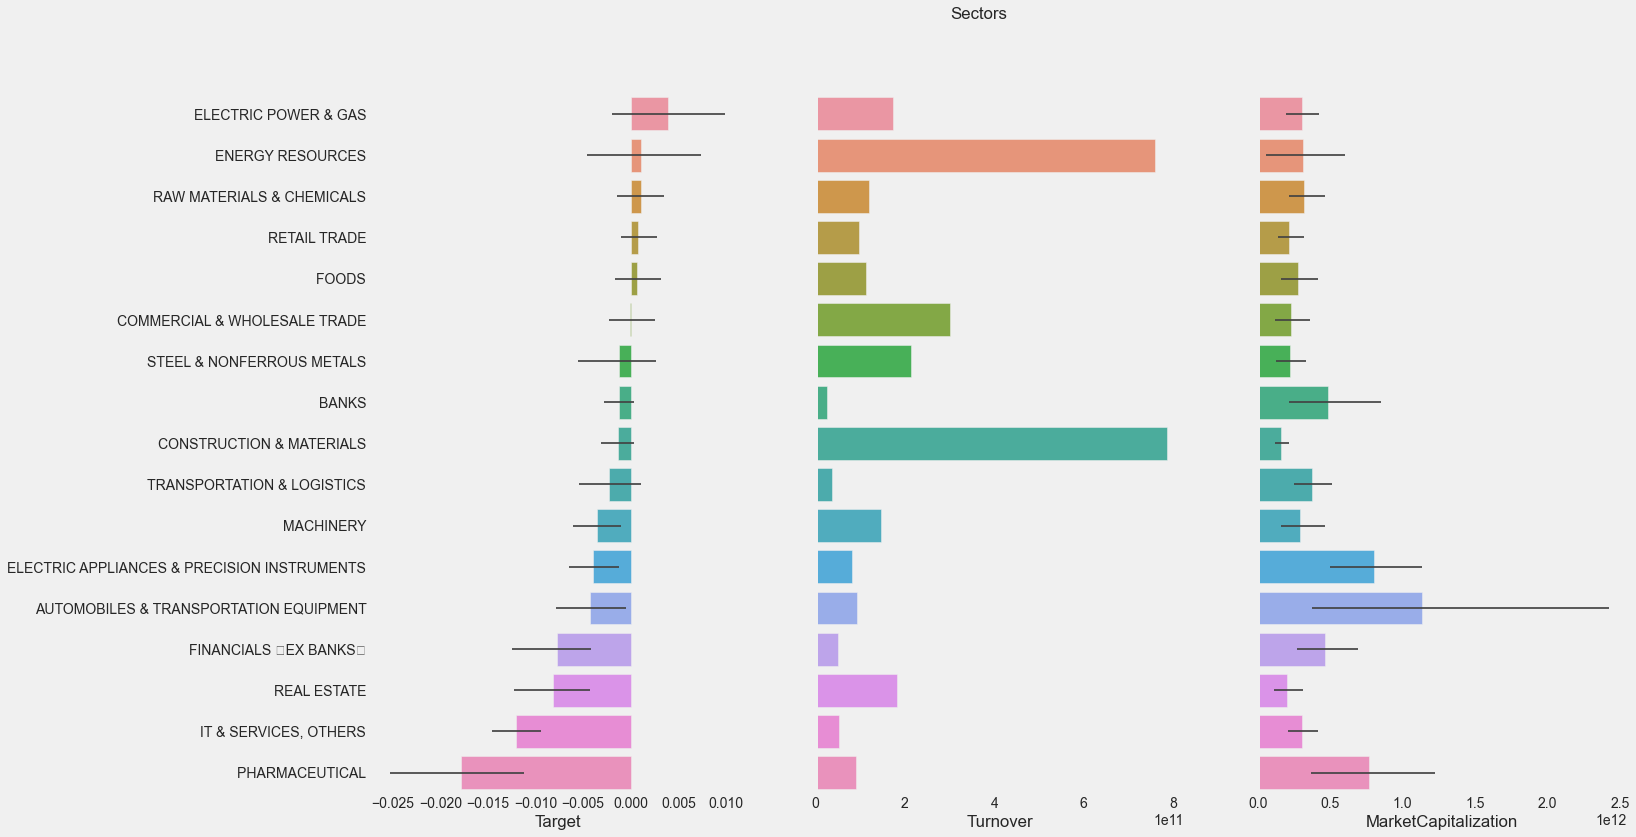

In [80]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(1,3, figsize=(20,12), sharey=True)
a = df.loc[df.index=='2021-12-02']
a['Turnover']= a.Close* a.Volume

sns.barplot(
    x='Target',
    y='17SectorName',
    data=a, ax=ax[0],
    errwidth=1.7,
    order= a.groupby('17SectorName').Target.mean().sort_values(ascending=False).index)

sns.barplot(
    x='Turnover',
    y='17SectorName',
    data=a, ax=ax[1],
    estimator= np.sum,
    ci=None,
    errwidth=1.7,
    order= a.groupby('17SectorName').MarketCapitalization.mean().sort_values(ascending=False).index)

sns.barplot(
    x='MarketCapitalization',
    y='17SectorName',
    data=a, ax=ax[2],
    #estimator= np.sum,
    #ci=None,
    errwidth=1.7,
    order= a.groupby('17SectorName').Target.mean().sort_values(ascending=False).index)


for i in ax:
    i.grid(False)
    i.set(ylabel=None)

fig.suptitle('Sectors')
fig.show()

#### Securities per Sector


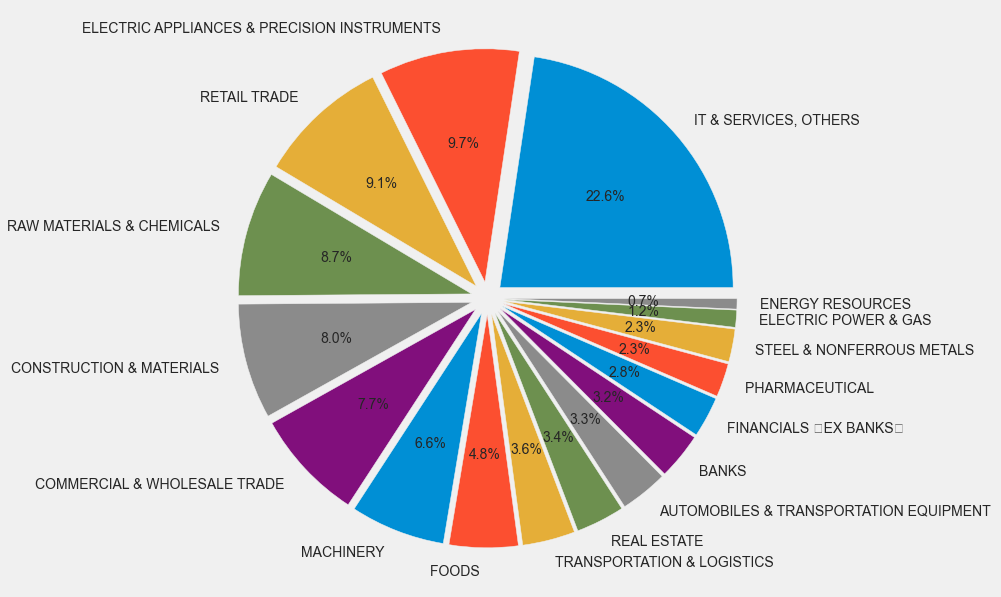

In [81]:
df['17SectorName'].value_counts().plot.pie(
    explode = [0.07 for i in range(17)],
    autopct='%1.1f%%',
    ylabel='',
    figsize=(20,10))


plt.show()

#### AUTOMOBILES & TRANSPORTATION EQUIPMENT Sector
AUTOMOBILES & TRANSPORTATION EQUIPMENT contribute Highest MarketCap in JPX markets. So we See all the stocks ups/downs in AUTOMOBILES & TRANSPORTATION EQUIPMENT sector..


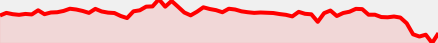
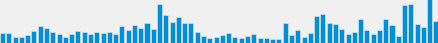
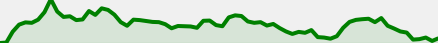
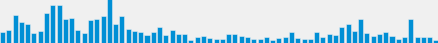
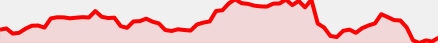
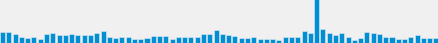
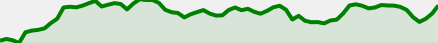
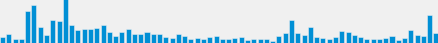
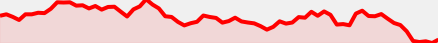
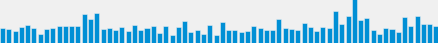
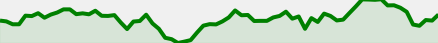
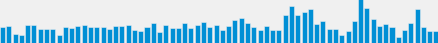
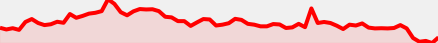
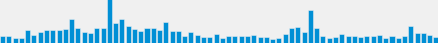
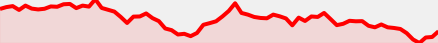
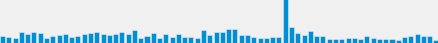
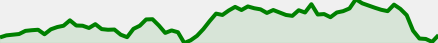
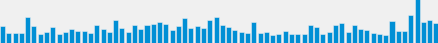
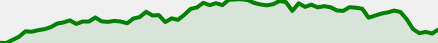
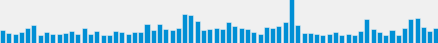
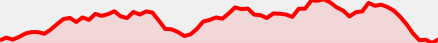
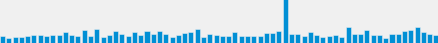
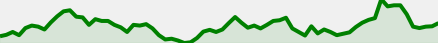
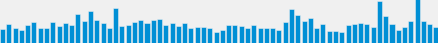
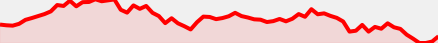
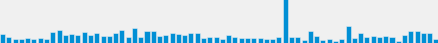
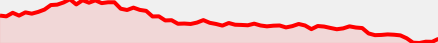
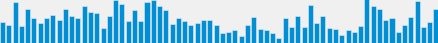
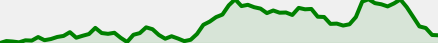
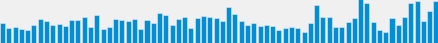
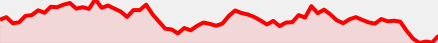
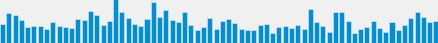
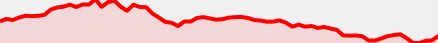
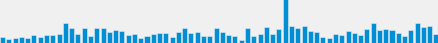
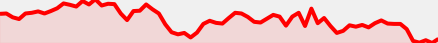
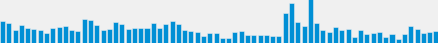
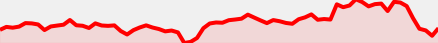
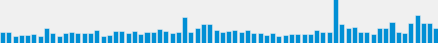
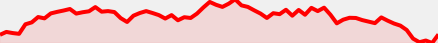
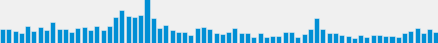
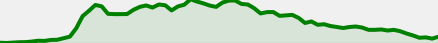
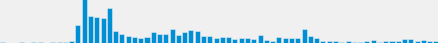
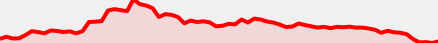
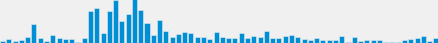
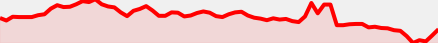
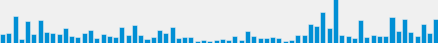
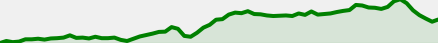
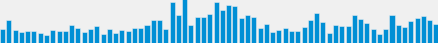
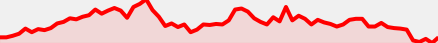
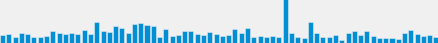
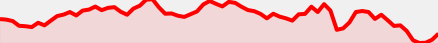
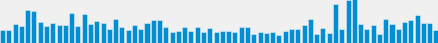
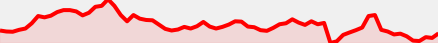
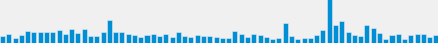
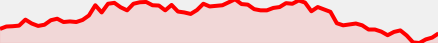
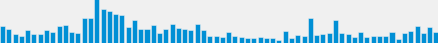
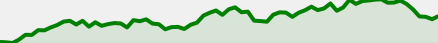
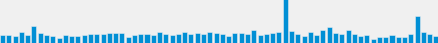
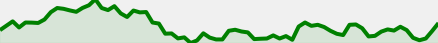
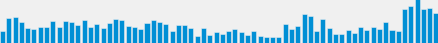
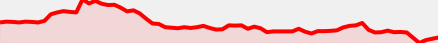
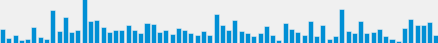
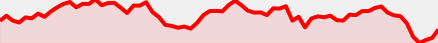
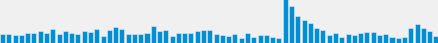
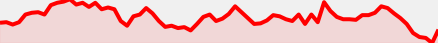
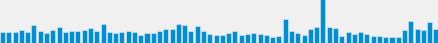
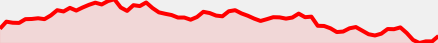
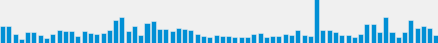
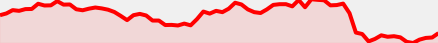
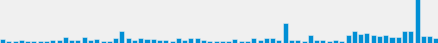
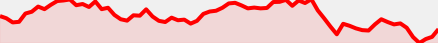
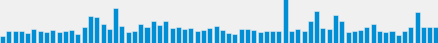
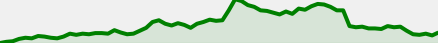
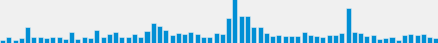
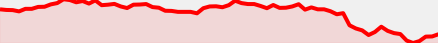
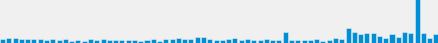
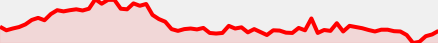
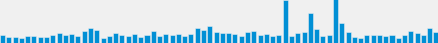
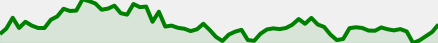
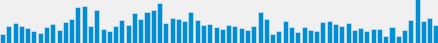
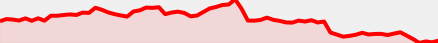
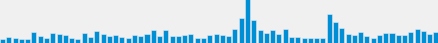
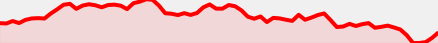
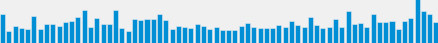
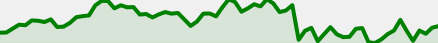
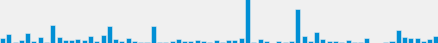
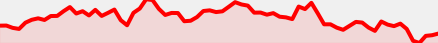
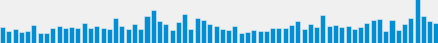
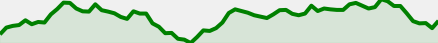
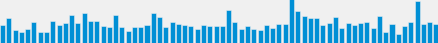
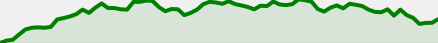
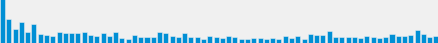
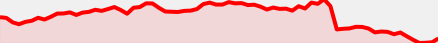
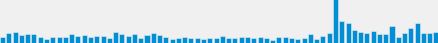
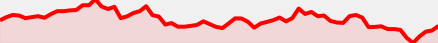
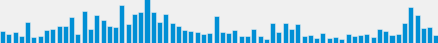
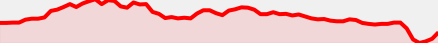
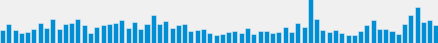
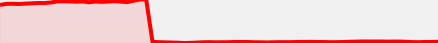
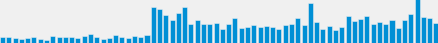
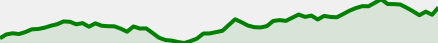
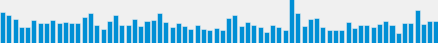
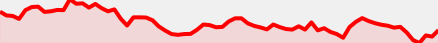
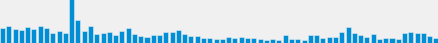
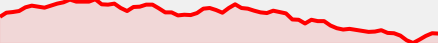
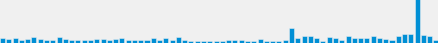
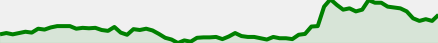
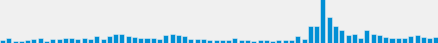
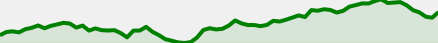
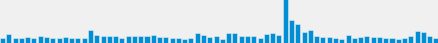
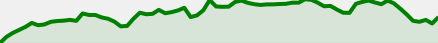
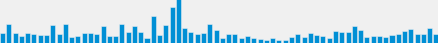
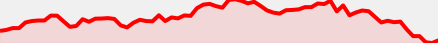
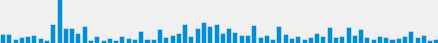
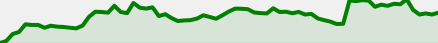
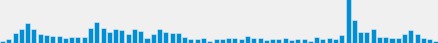
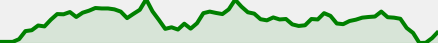
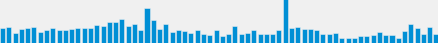
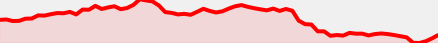
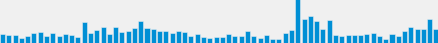
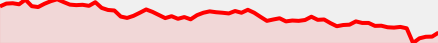
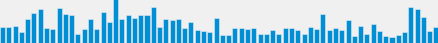
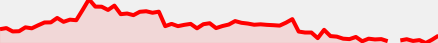
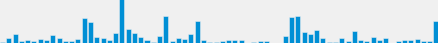
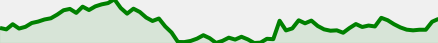
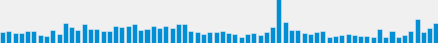
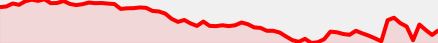
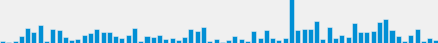

In [82]:
show_table(df =df[df['17SectorName'] =='AUTOMOBILES & TRANSPORTATION EQUIPMENT '], num_of_rows=100)

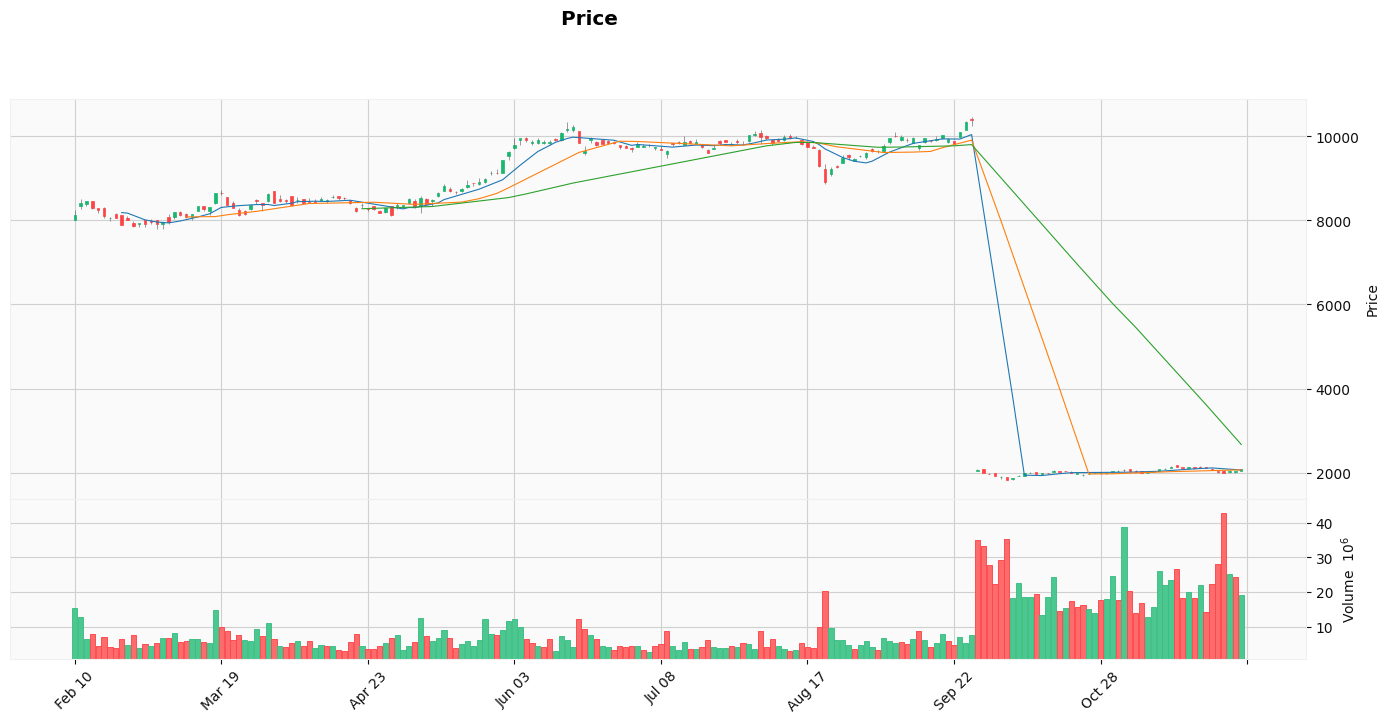

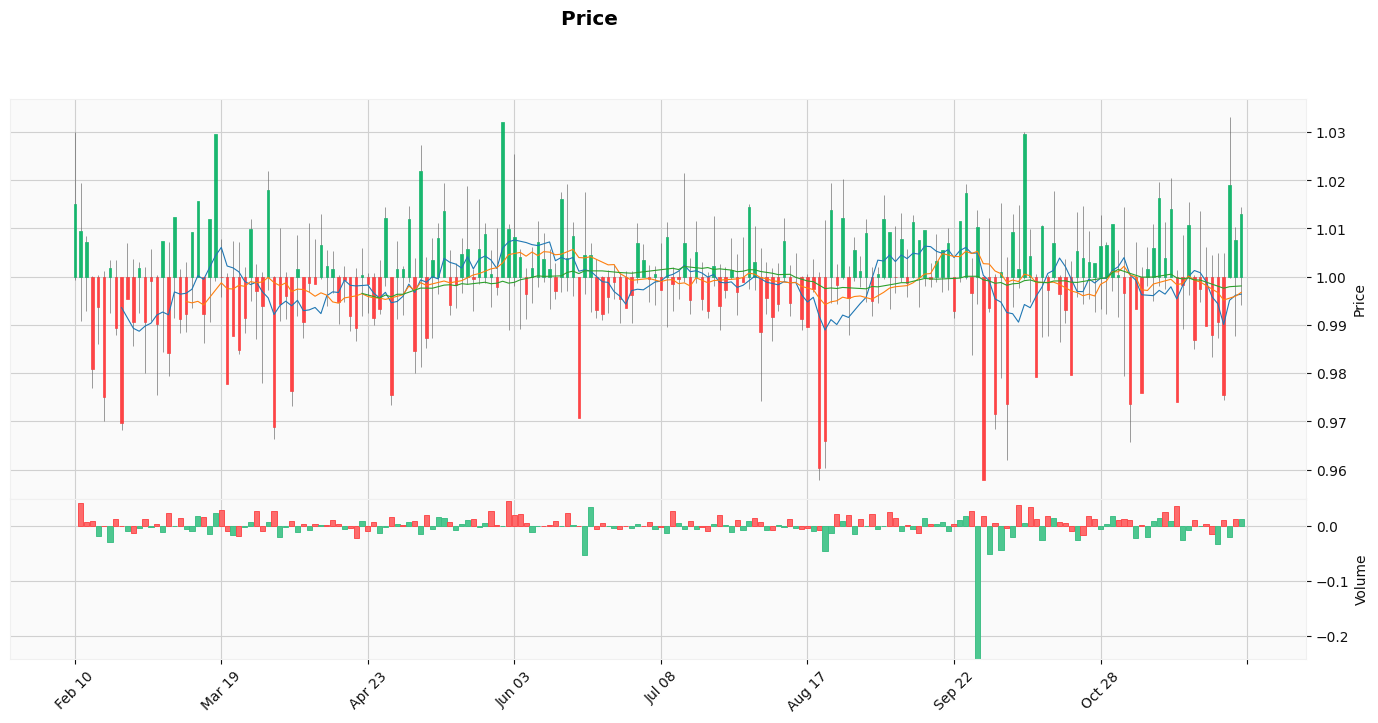

In [83]:
a= df[df.SecuritiesCode==7203].iloc[-200:]
mpl.plot(
    a,
    type="candle",
    volume=True,
    mav =(9,20,50),
    title = f" Price",  
    style='yahoo',
    figsize=(18,8))

a.Volume= a.Open.pct_change()
a[['Open', 'High', 'Low', 'Close']] = a[['Open', 'High', 'Low', 'Close']].divide(a.Open, axis= 0)
#a.Volume =a.Volume.pct_change()

mpl.plot(
    a,
    type="candle",
    volume=True,
    mav =(9,20, 50),
    title = f" Price",  
    style='yahoo',
    figsize=(18,8))

### Conclusion:
We have successfully explored our data set and now we have idea of our dataset. we shall explore in subsequent notebooks the Stock_price & Stock_list and attempt to predict some stocks 